In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize': (11.7, 8.27)})

# Shalbourne Gliding Flight Logs Analysis
Author: <A.Pilko@soton.ac.uk>

# 1. Load and Clean data
![](https://imgs.xkcd.com/comics/data_trap.png)

In [2]:
flights_df = pd.concat([pd.read_csv(path) for path in glob.glob("../data/flightlogs/*.csv")]).drop(labels=['No'],
                                                                                                   axis=1)
flights_df.head()

,Date,P1,P2,Glider,Takeoff,FlightTime,Comment
0,2019-01-02,Stephen Ottner,Bob Symons,HCF,11:34:00,00:05:00,NaN
1,2019-01-02,Bob Boyd,NaN,JPC,11:38:00,00:09:00,NaN
2,2019-01-02,Stephen Ottner,Bob Symons,HCF,11:52:00,00:02:00,Train launch failure - FOC launch
3,2019-01-02,Colin Baines,Paul Bryant,JPC,12:07:00,00:06:00,NaN
4,2019-01-02,Paul Prentice,NaN,DHA,12:18:00,00:08:00,NaN


In [3]:
# Assign some types
flights_df['Date'] = pd.to_datetime(flights_df['Date'])
flights_df['Glider'] = flights_df['Glider'].astype(str)
flights_df['Takeoff'] = pd.to_datetime(flights_df['Takeoff'])
flights_df['FlightTime'] = pd.to_timedelta(flights_df['FlightTime'])
flights_df['Comment'] = flights_df['Comment'].astype(str)


# Replace takeoff date with actual date of flight
def replace_takeoff_date(row):
    row['Takeoff'] = row['Takeoff'].replace(year=row['Date'].year, month=row['Date'].month, day=row['Date'].day)
    return row


flights_df = flights_df.apply(replace_takeoff_date, axis=1)

/tmp/ipykernel_871628/931581169.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  flights_df['Takeoff'] = pd.to_datetime(flights_df['Takeoff'])


In [4]:
# Replace expected NaNs
flights_df['Comment'] = flights_df['Comment'].replace('nan', '')
flights_df['P2'] = flights_df['P2'].replace('nan', '').replace(np.nan, '')

# Break out takeoff time into hour and minute for less pain later
flights_df['TakeoffMinute'] = flights_df['Takeoff'].dt.minute
# Make decimal hours
flights_df['TakeoffHour'] = flights_df['Takeoff'].dt.hour + flights_df['TakeoffMinute'] / 60

# Get rid of anomalies
flights_df = flights_df[flights_df['TakeoffHour'] > 7]
flights_df = flights_df[flights_df['TakeoffHour'] < 20]


# 2. Pretty Plot Profit

## Data Range Aggregate Times

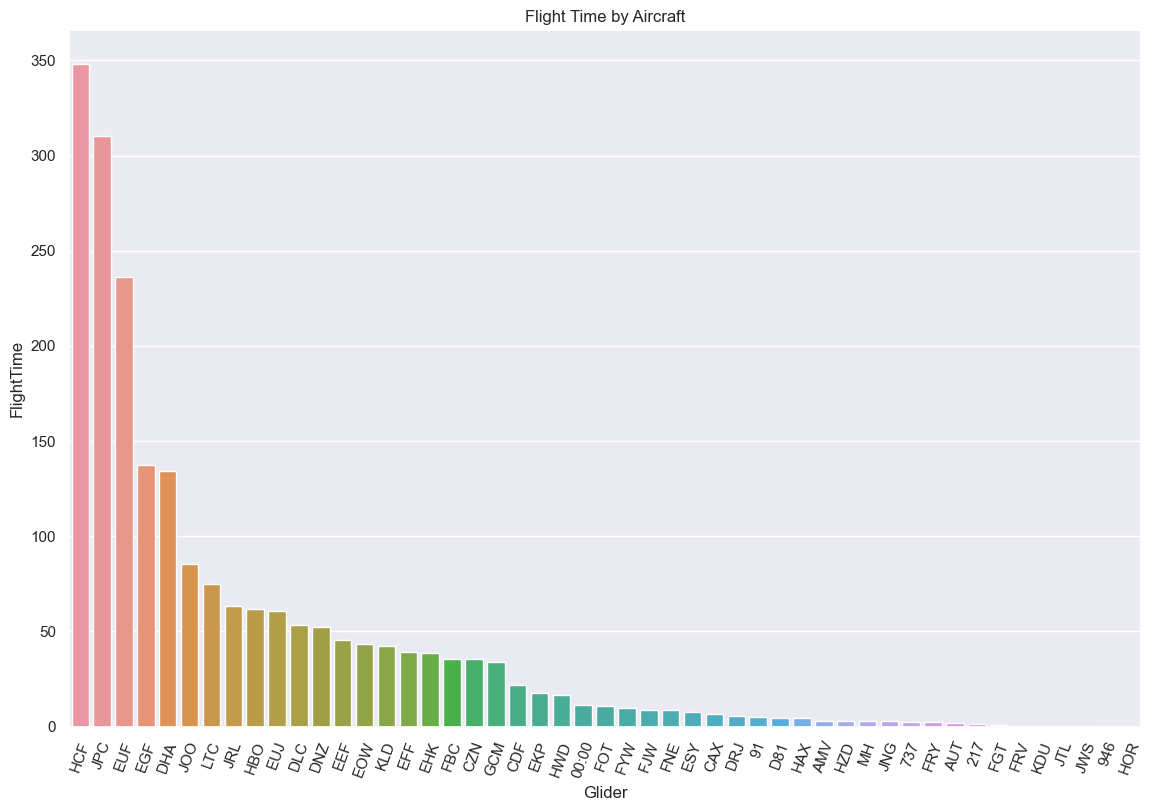

In [5]:
agg_aircraft = flights_df.groupby('Glider').aggregate({'FlightTime': 'sum', 'Takeoff': 'count'}).sort_values(
    by='FlightTime', ascending=False)
sns.barplot(x=agg_aircraft.index, y=agg_aircraft['FlightTime'].dt.total_seconds() / 3600)
plt.xticks(rotation=70)
plt.title('Flight Time by Aircraft')
plt.tight_layout()

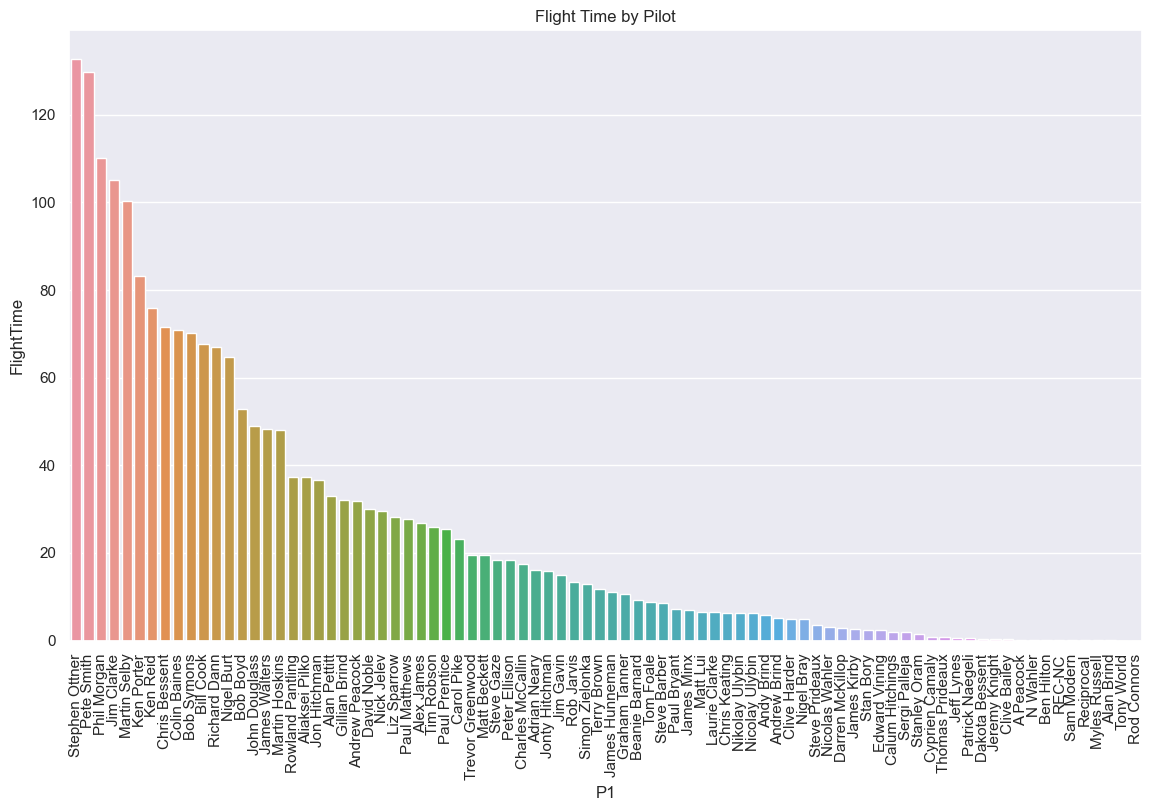

In [6]:
agg_p1 = flights_df.groupby('P1').aggregate({'FlightTime': 'sum', 'Takeoff': 'count'}).sort_values(by='FlightTime',
                                                                                                   ascending=False)
sns.barplot(x=agg_p1.index, y=agg_p1['FlightTime'].dt.total_seconds() / 3600)
plt.xticks(rotation=90)
plt.title('Flight Time by Pilot')
plt.tight_layout()

## Watch and Learn(?)

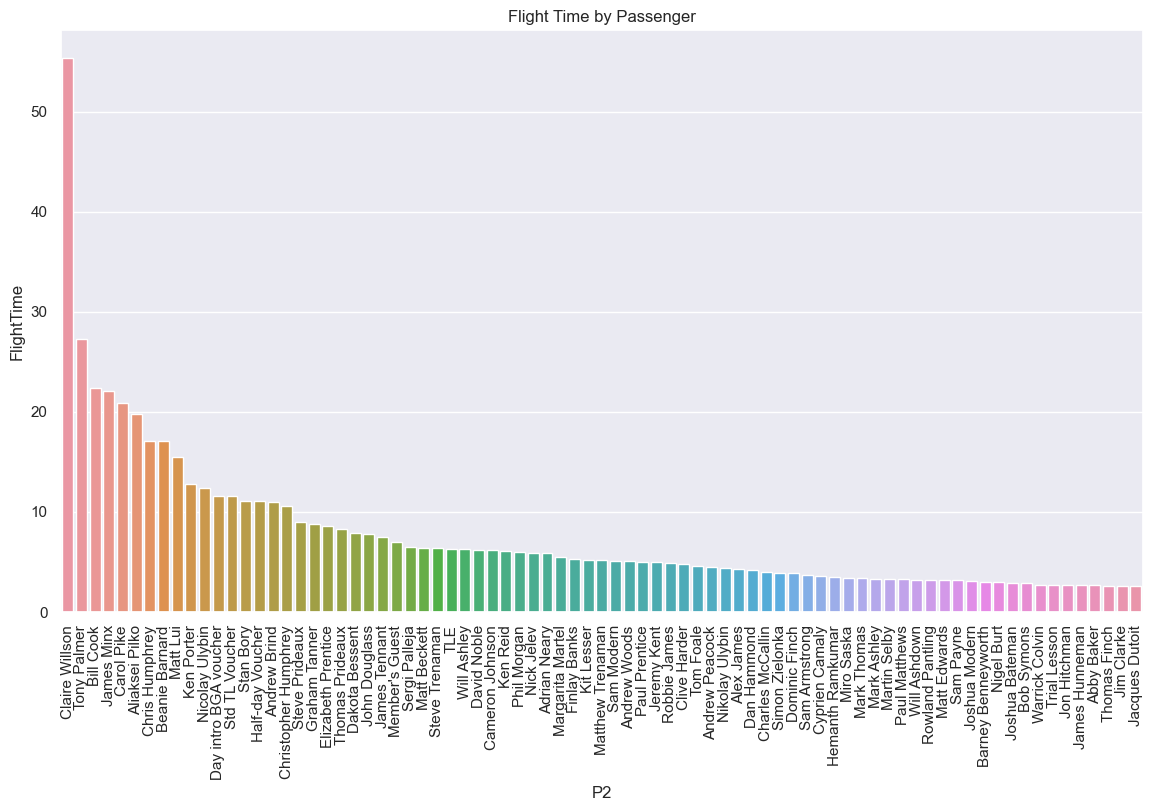

In [7]:
agg_p2 = flights_df.groupby('P2').aggregate({'FlightTime': 'sum', 'Takeoff': 'count'}).sort_values(by='FlightTime',
                                                                                                   ascending=False).iloc[
         1:80]
sns.barplot(x=agg_p2.index, y=agg_p2['FlightTime'].dt.total_seconds() / 3600)
plt.xticks(rotation=90)
plt.title('Flight Time by Passenger')
plt.tight_layout()

## Syndicates fly more

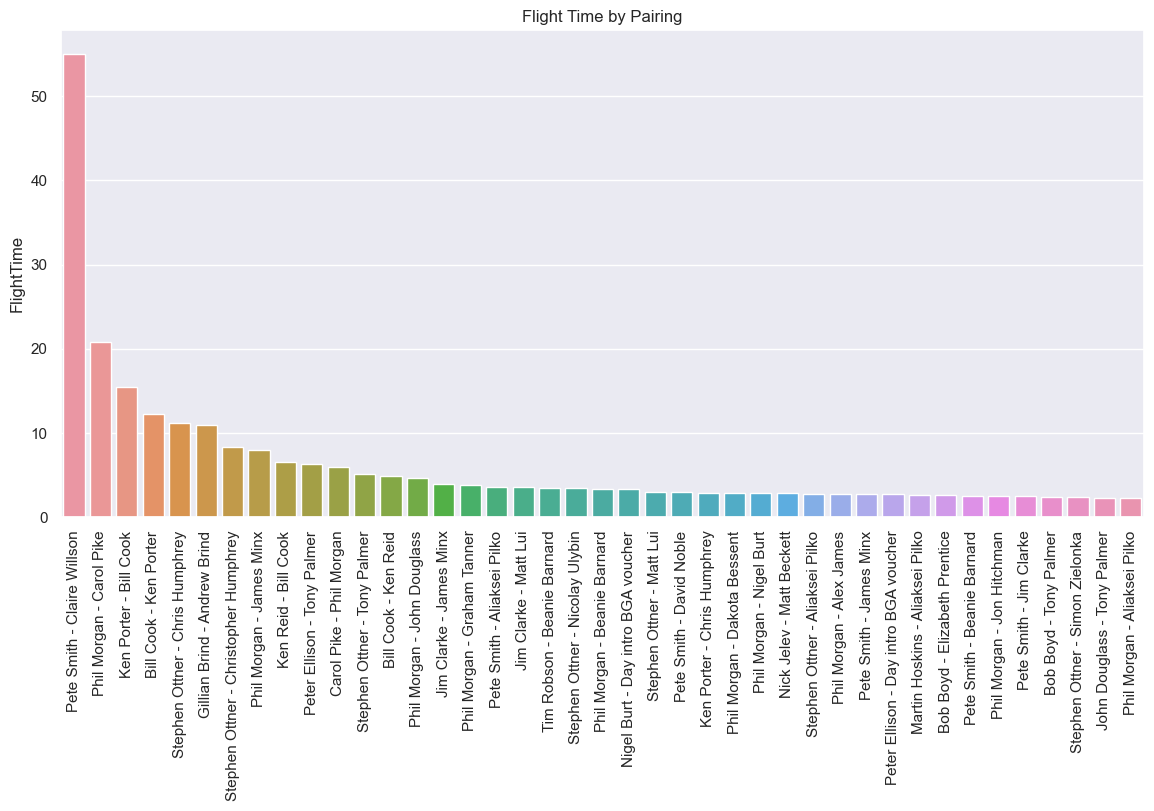

In [8]:
agg_p1_p2 = flights_df.groupby(['P1', 'P2']).aggregate({'FlightTime': 'sum', 'Takeoff': 'count'}).sort_values(
    by='FlightTime', ascending=False).reset_index().iloc[:100]
agg_p1_p2 = agg_p1_p2[agg_p1_p2['P2'] != '']
sns.barplot(x=agg_p1_p2['P1'] + ' - ' + agg_p1_p2['P2'], y=agg_p1_p2['FlightTime'].dt.total_seconds() / 3600)
plt.xticks(rotation=90)
plt.title('Flight Time by Pairing')
plt.tight_layout()

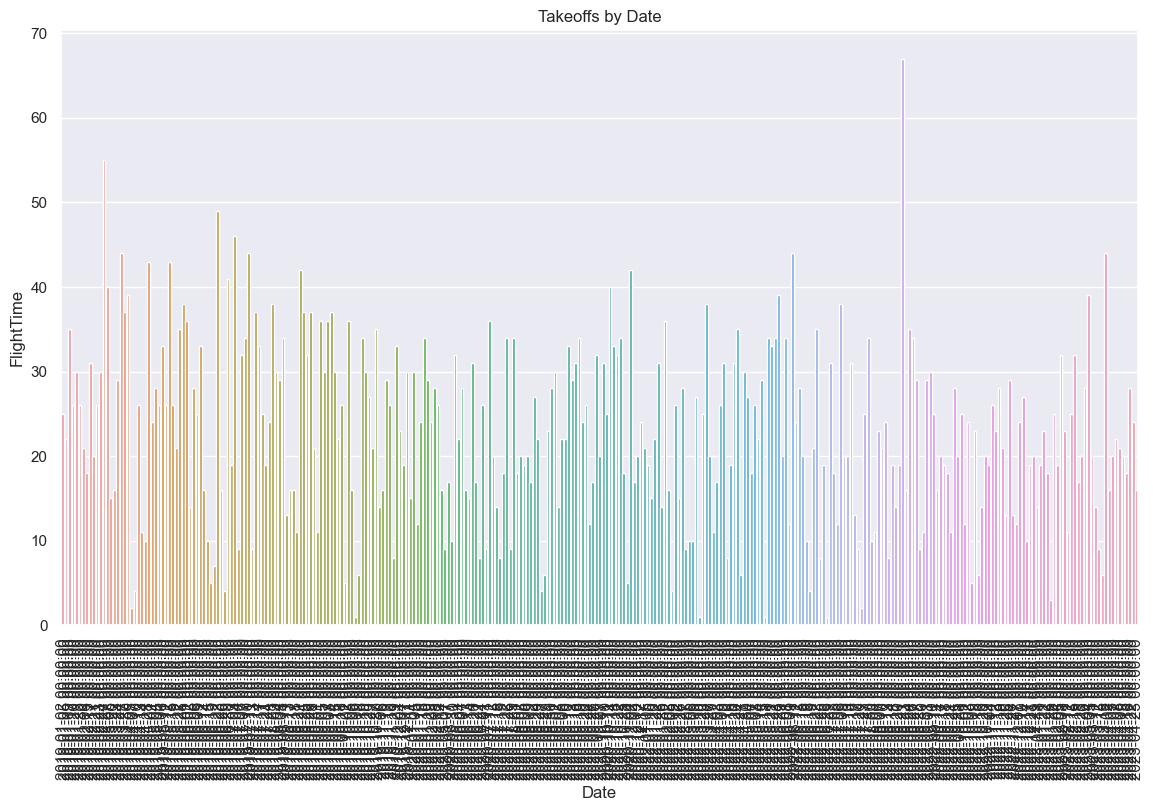

In [9]:
# Good luck reading the labels
takeoffs_by_date = flights_df.groupby(flights_df['Date'])
sns.barplot(x=takeoffs_by_date['Date'].first(), y=takeoffs_by_date['FlightTime'].count())
plt.xticks(rotation=90)
plt.title('Takeoffs by Date')
plt.tight_layout()

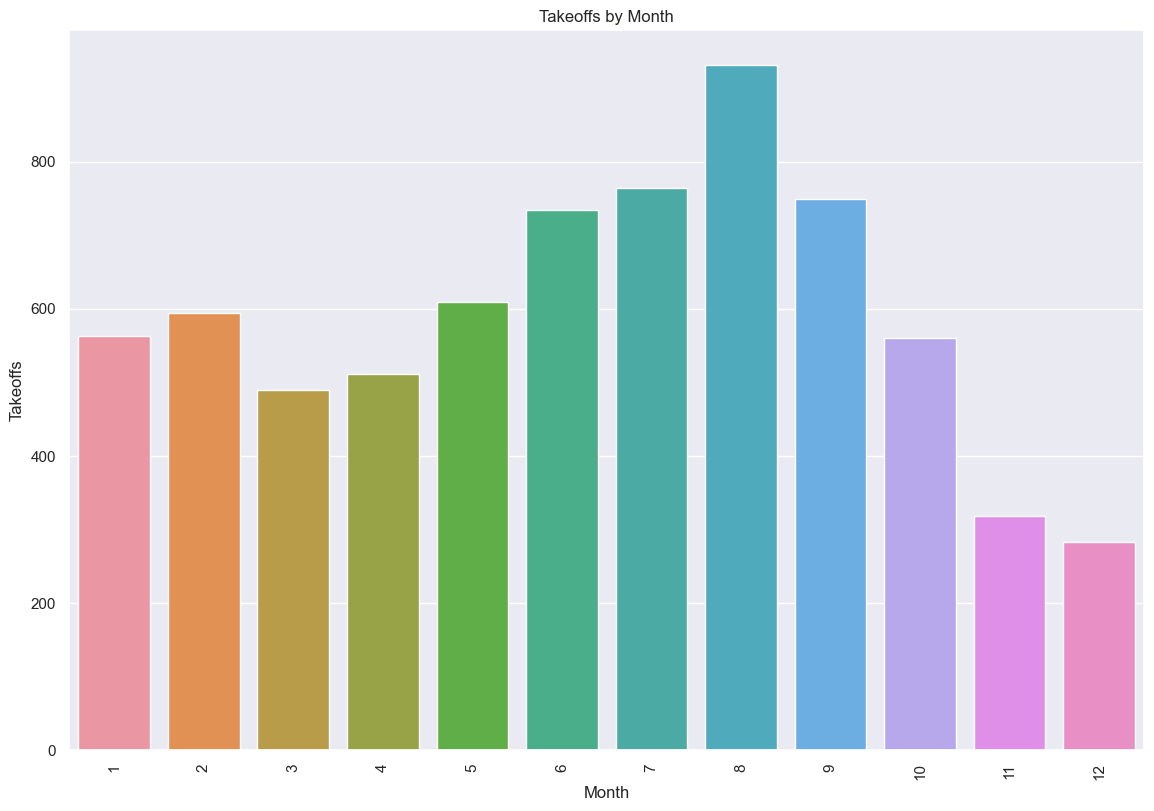

In [10]:
takeoff_by_month = flights_df.groupby(flights_df['Takeoff'].dt.month).aggregate({'FlightTime': 'count'})
sns.barplot(x=takeoff_by_month.index, y=takeoff_by_month['FlightTime'])
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Takeoffs')
plt.title('Takeoffs by Month')
plt.tight_layout()

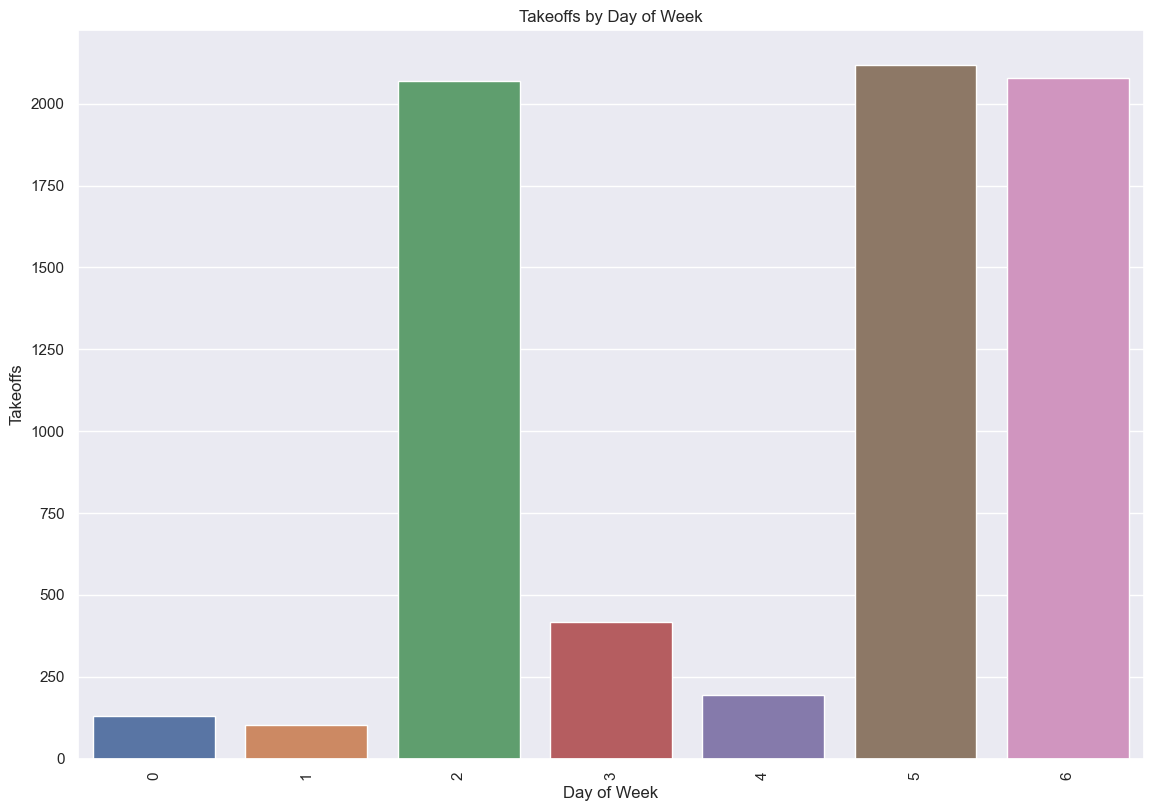

In [11]:
takeoff_by_day = flights_df.groupby(flights_df['Takeoff'].dt.dayofweek).aggregate({'FlightTime': 'count'})
sns.barplot(x=takeoff_by_day.index, y=takeoff_by_day['FlightTime'])
plt.xticks(rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Takeoffs')
plt.title('Takeoffs by Day of Week')
plt.tight_layout()

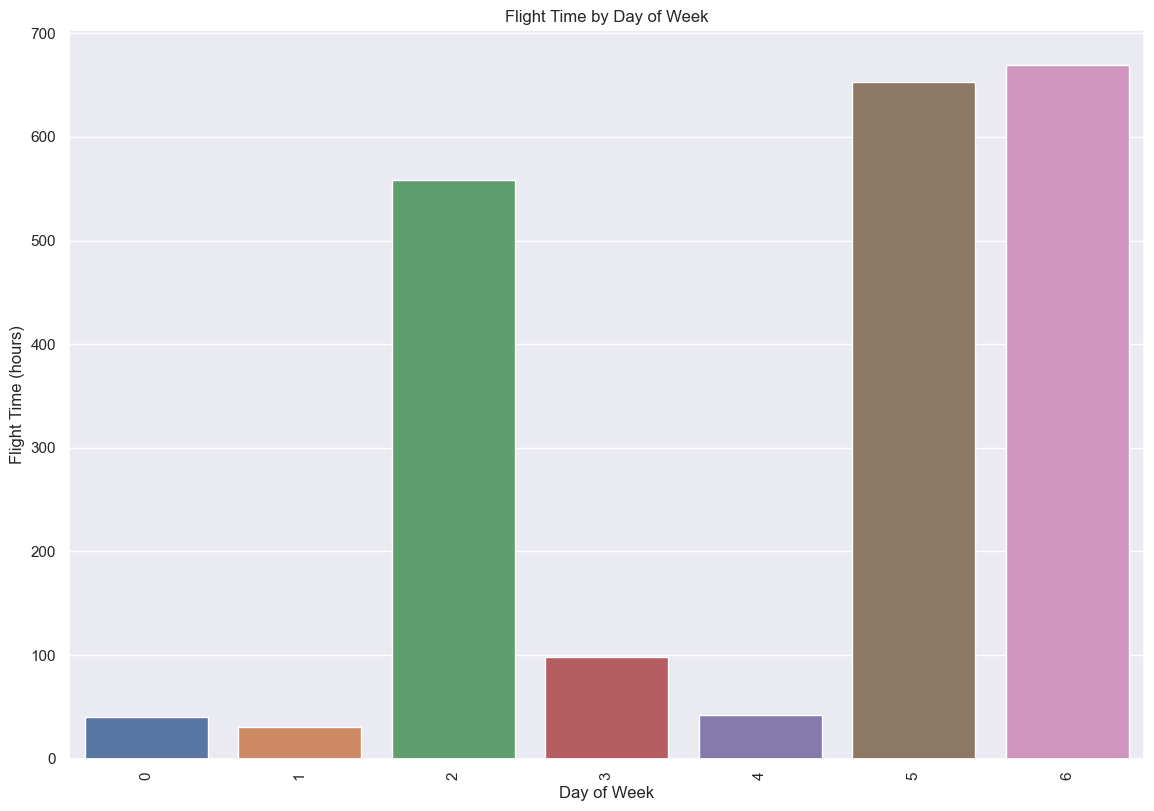

In [12]:
flight_time_by_day = flights_df.groupby(flights_df['Takeoff'].dt.dayofweek).aggregate({'FlightTime': 'sum'})
sns.barplot(x=flight_time_by_day.index, y=flight_time_by_day['FlightTime'].dt.total_seconds() / 3600)
plt.xticks(rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Flight Time (hours)')
plt.title('Flight Time by Day of Week')
plt.tight_layout()

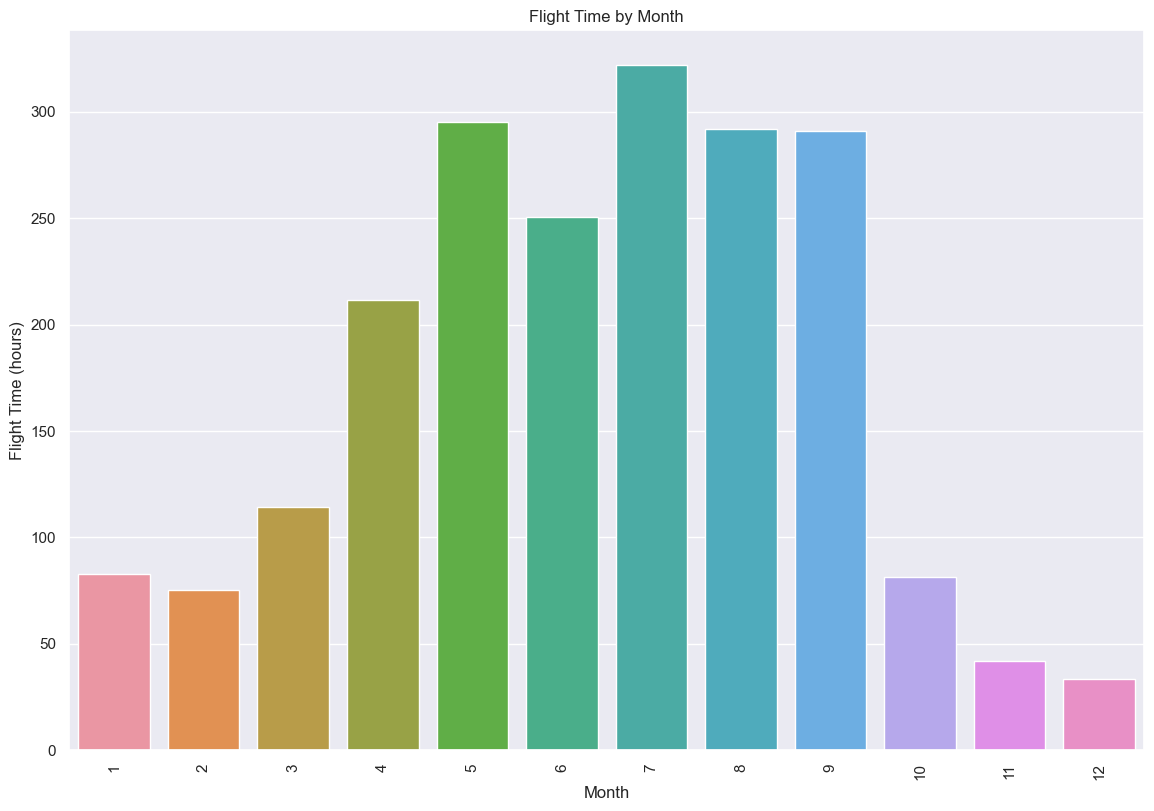

In [13]:
flight_time_by_month = flights_df.groupby(flights_df['Takeoff'].dt.month).aggregate({'FlightTime': 'sum'})
sns.barplot(x=flight_time_by_month.index, y=flight_time_by_month['FlightTime'].dt.total_seconds() / 3600)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Flight Time (hours)')
plt.title('Flight Time by Month')
plt.tight_layout()

## Mean Flight Times

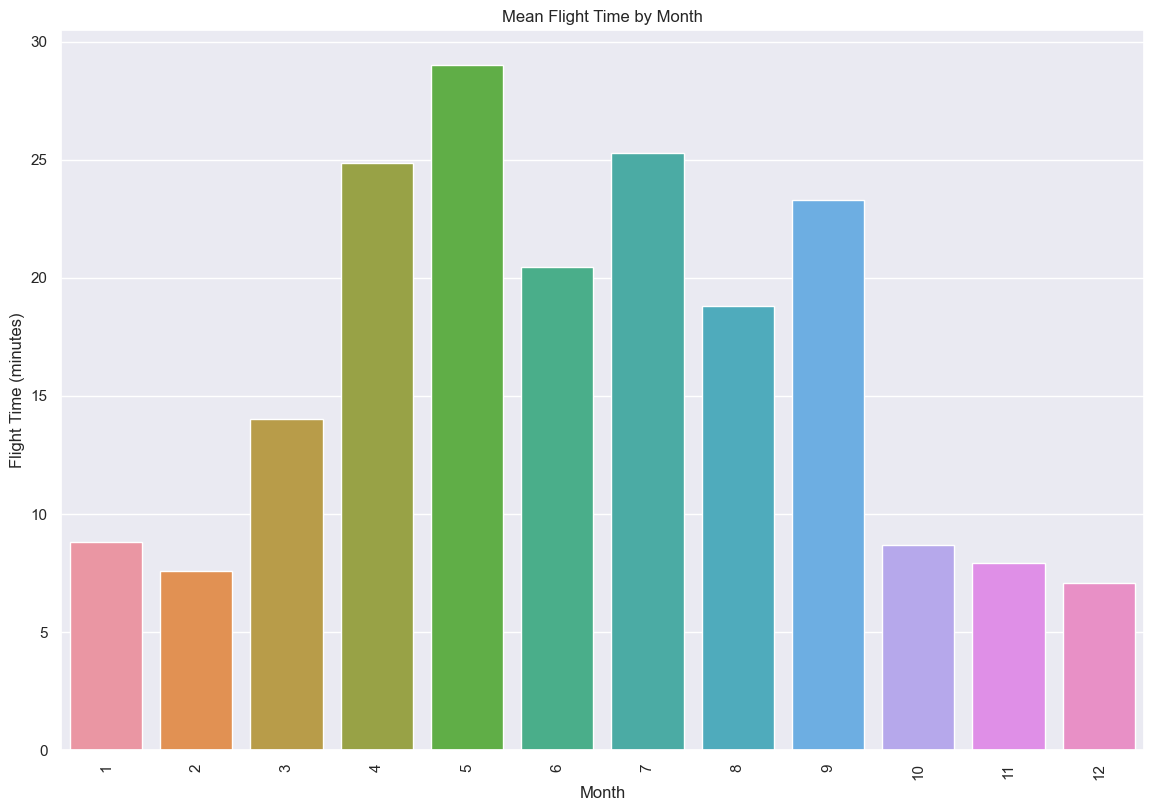

In [14]:
mean_flight_time_by_month = flights_df.groupby(flights_df['Takeoff'].dt.month).aggregate({'FlightTime': 'mean'})
sns.barplot(x=mean_flight_time_by_month.index, y=mean_flight_time_by_month['FlightTime'].dt.total_seconds() / 60)
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Flight Time (minutes)')
plt.title('Mean Flight Time by Month')
plt.tight_layout()

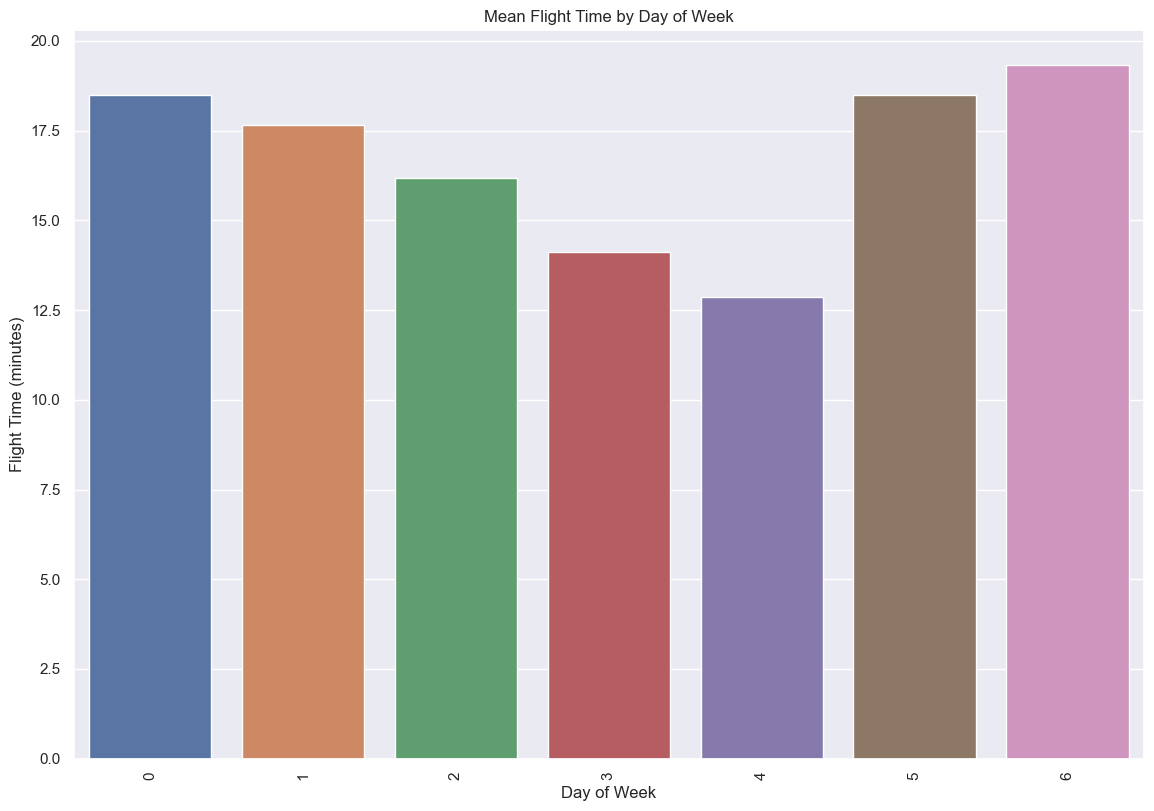

In [15]:
mean_flight_time_by_day = flights_df.groupby(flights_df['Takeoff'].dt.dayofweek).aggregate({'FlightTime': 'mean'})
sns.barplot(x=mean_flight_time_by_day.index, y=mean_flight_time_by_day['FlightTime'].dt.total_seconds() / 60)
plt.xticks(rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Flight Time (minutes)')
plt.title('Mean Flight Time by Day of Week')
plt.tight_layout()

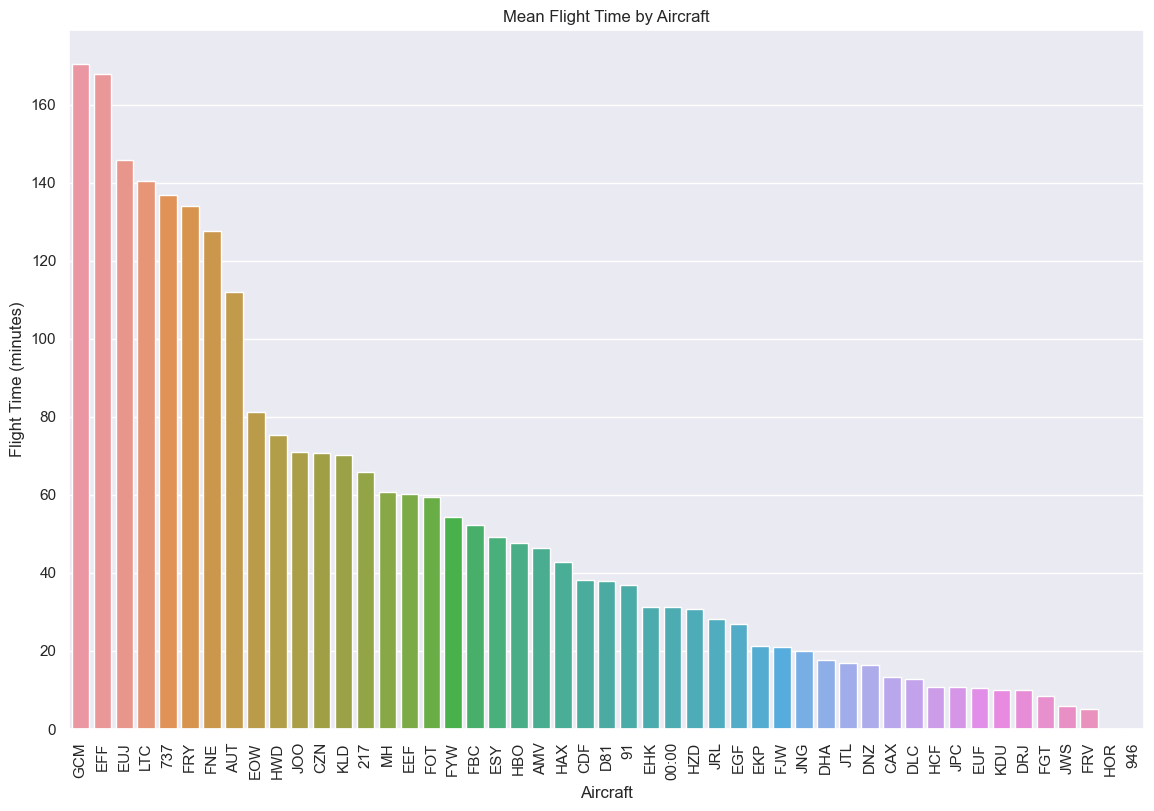

In [16]:
mean_flight_time_by_aircraft = flights_df.groupby(flights_df['Glider']).aggregate({'FlightTime': 'mean'}).sort_values(
    by='FlightTime', ascending=False)
sns.barplot(x=mean_flight_time_by_aircraft.index, y=mean_flight_time_by_aircraft['FlightTime'].dt.total_seconds() / 60)
plt.xticks(rotation=90)
plt.xlabel('Aircraft')
plt.ylabel('Flight Time (minutes)')
plt.title('Mean Flight Time by Aircraft')
plt.tight_layout()

## Daily
Reminder that just because you *can* draw a best fit line, doesn't mean you *should* draw a best fit line.
![](https://imgs.xkcd.com/comics/linear_regression.png)
Unfortunately, seaborn make this too easy, so best fit lines all around!

In [17]:
day_grouped = flights_df.groupby(flights_df['Takeoff'].dt.date)

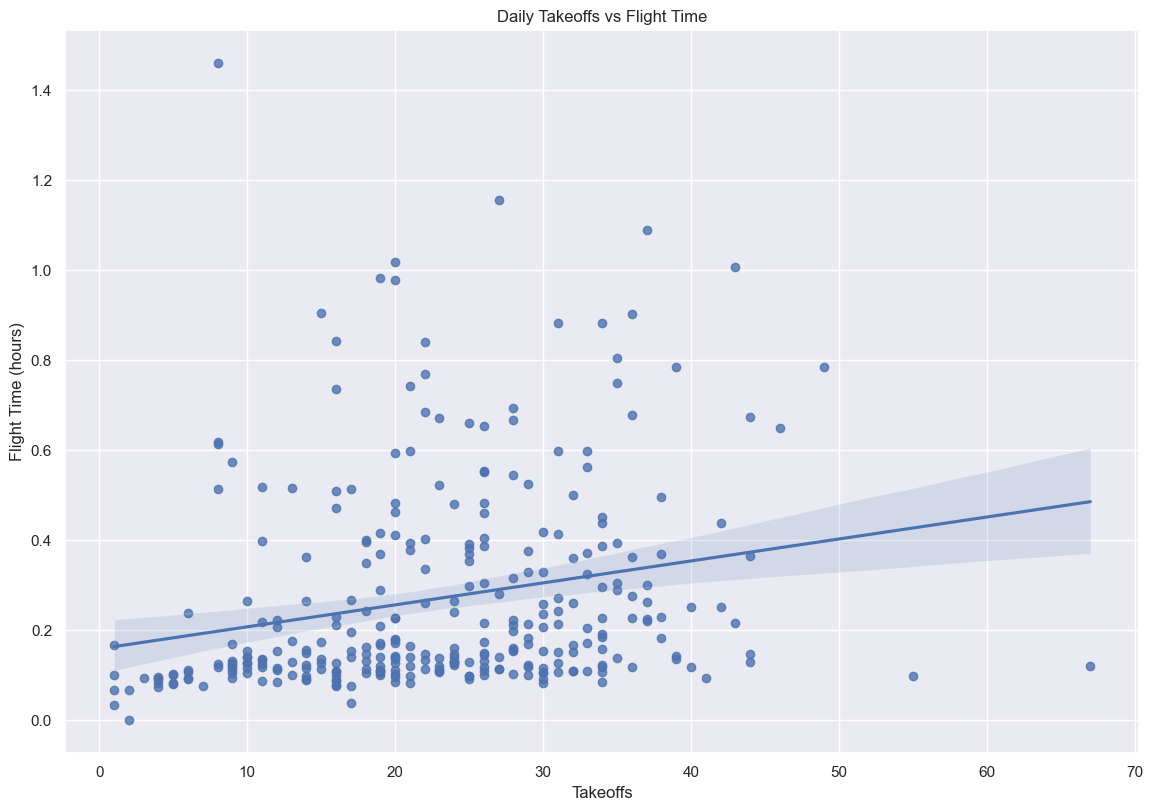

In [18]:
daily_takeoffs_vs_flight_time = day_grouped.aggregate({'FlightTime': 'mean', 'Takeoff': 'count'})
sns.regplot(x=daily_takeoffs_vs_flight_time['Takeoff'],
                y=daily_takeoffs_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('Takeoffs')
plt.ylabel('Flight Time (hours)')
plt.title('Daily Takeoffs vs Flight Time')
plt.tight_layout()

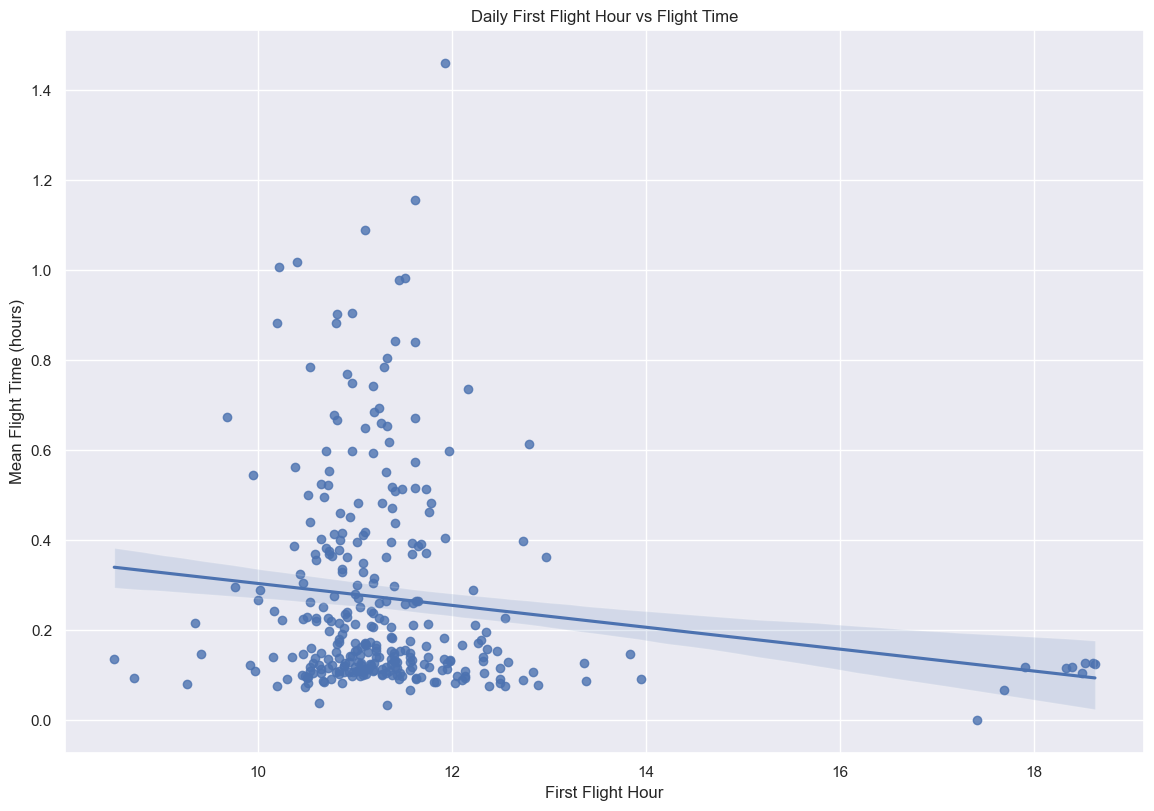

In [19]:
daily_first_flight_hour_vs_flight_time = day_grouped.aggregate({'FlightTime': 'mean', 'TakeoffHour': 'min'})
sns.regplot(x=daily_first_flight_hour_vs_flight_time['TakeoffHour'],
                y=daily_first_flight_hour_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('First Flight Hour')
plt.ylabel('Mean Flight Time (hours)')
plt.title('Daily First Flight Hour vs Flight Time')
plt.tight_layout()

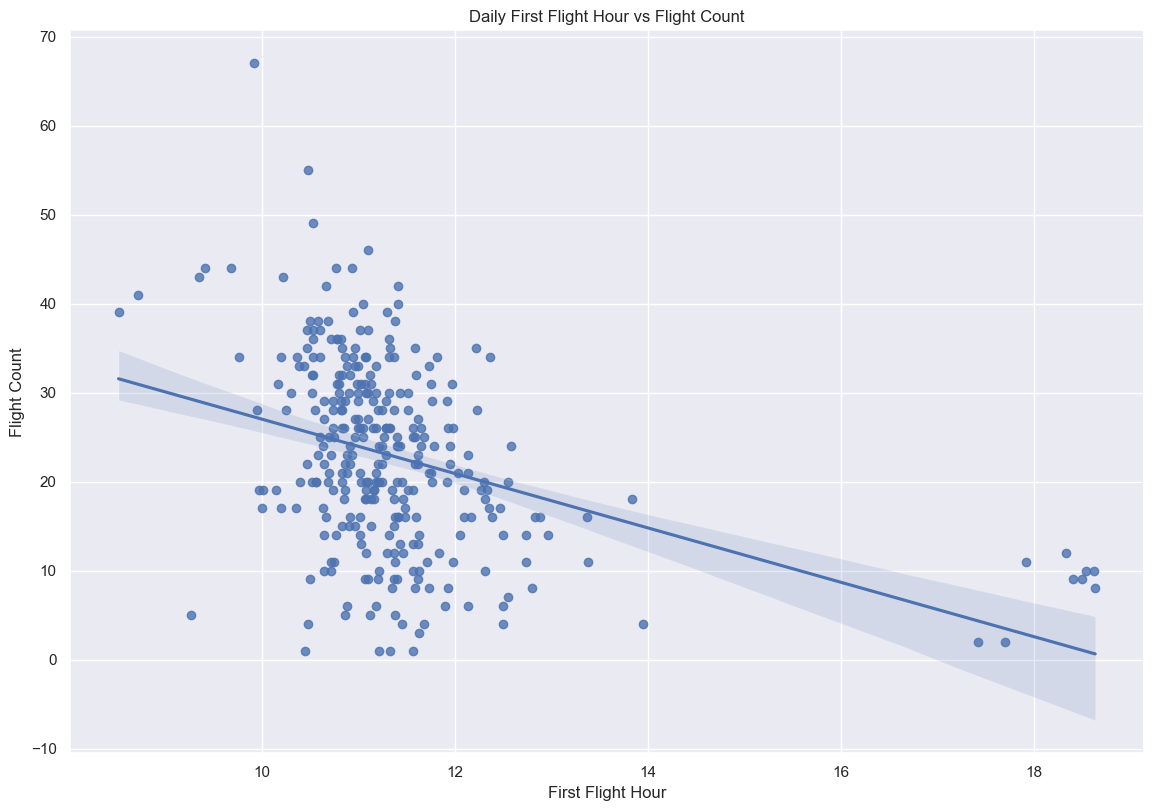

In [20]:
daily_first_flight_hour_vs_flight_count = day_grouped.aggregate({'FlightTime': 'count', 'TakeoffHour': 'min'})
sns.regplot(x=daily_first_flight_hour_vs_flight_count['TakeoffHour'],
                y=daily_first_flight_hour_vs_flight_count['FlightTime'])
plt.xlabel('First Flight Hour')
plt.ylabel('Flight Count')
plt.title('Daily First Flight Hour vs Flight Count')
plt.tight_layout()

## Daily Churn of P2s

In [21]:
unique_p2_by_day = day_grouped.aggregate({'P2': 'nunique'}).reset_index()
unique_p2_by_day['Takeoff'] = pd.to_datetime(unique_p2_by_day['Takeoff'])

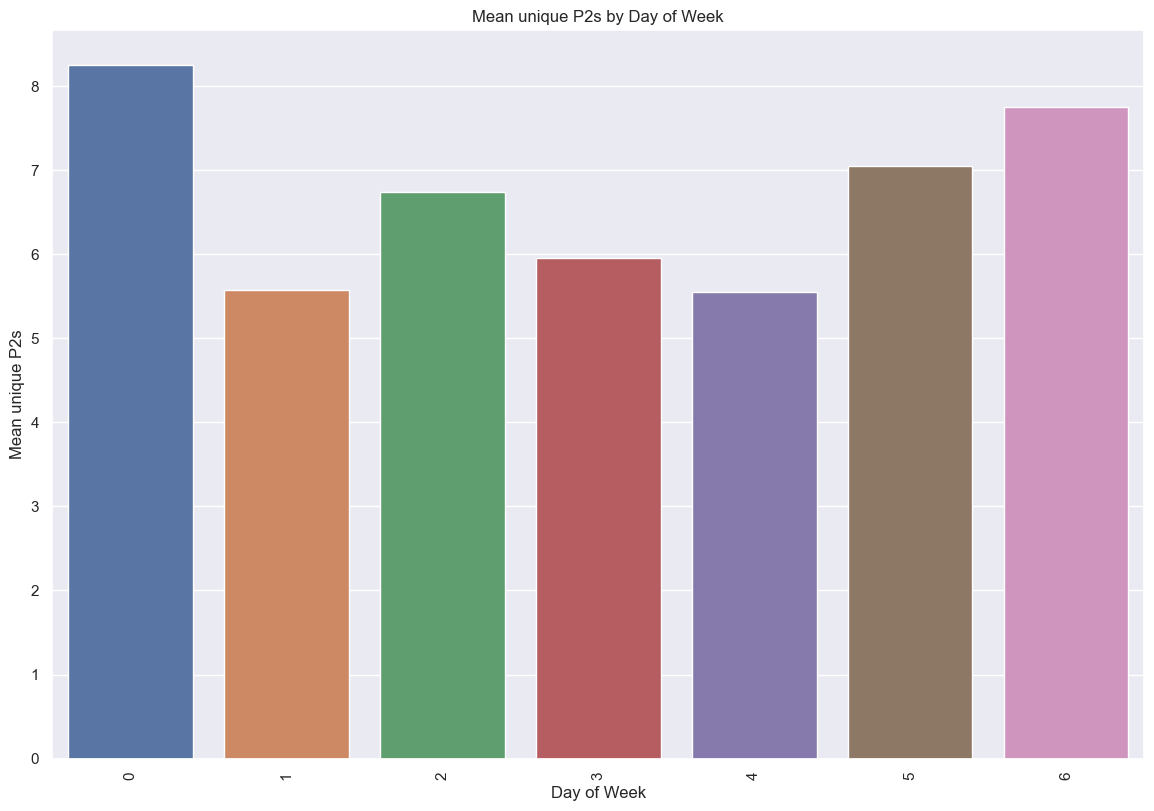

In [22]:
unique_p2_per_day_of_week = unique_p2_by_day.groupby(unique_p2_by_day['Takeoff'].dt.dayofweek).aggregate({'P2': 'mean'})
sns.barplot(x=unique_p2_per_day_of_week.index, y=unique_p2_per_day_of_week['P2'])
plt.xticks(rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Mean unique P2s')
plt.title('Mean unique P2s by Day of Week')
plt.tight_layout()

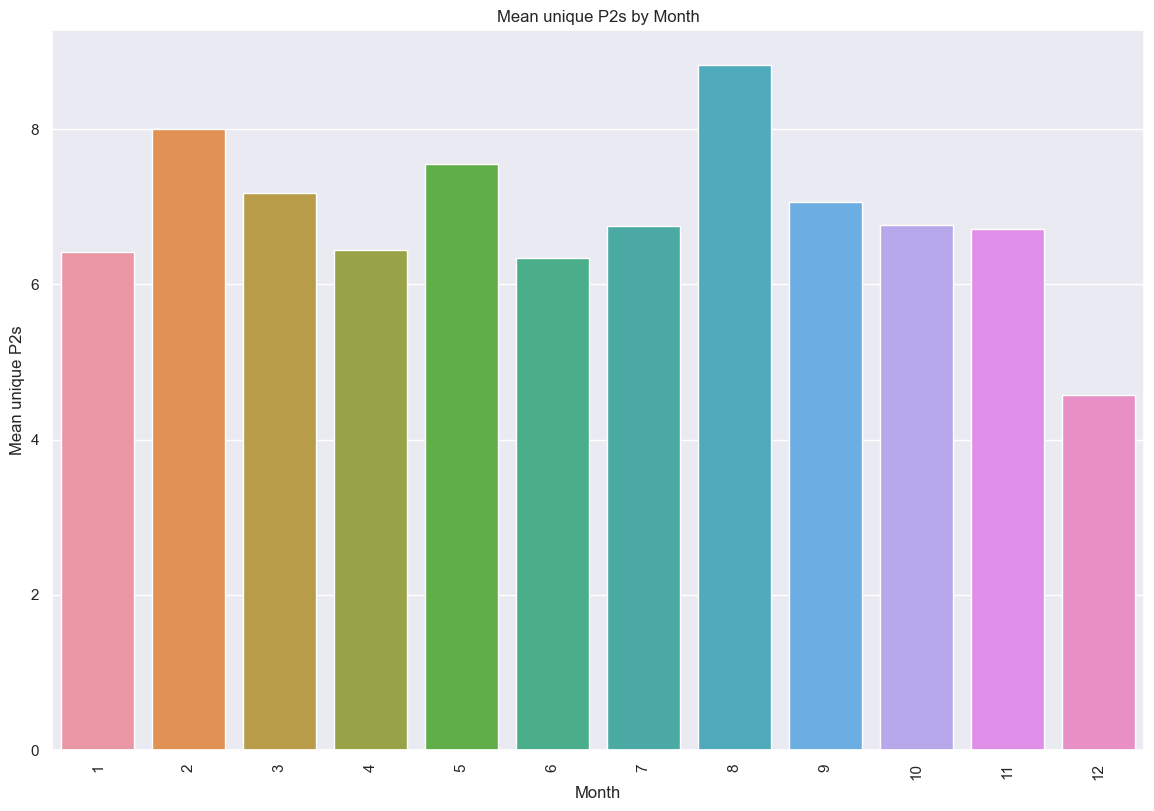

In [23]:
unique_p2_per_month = unique_p2_by_day.groupby(unique_p2_by_day['Takeoff'].dt.month).aggregate({'P2': 'mean'})
sns.barplot(x=unique_p2_per_month.index, y=unique_p2_per_month['P2'])
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Mean unique P2s')
plt.title('Mean unique P2s by Month')
plt.tight_layout()

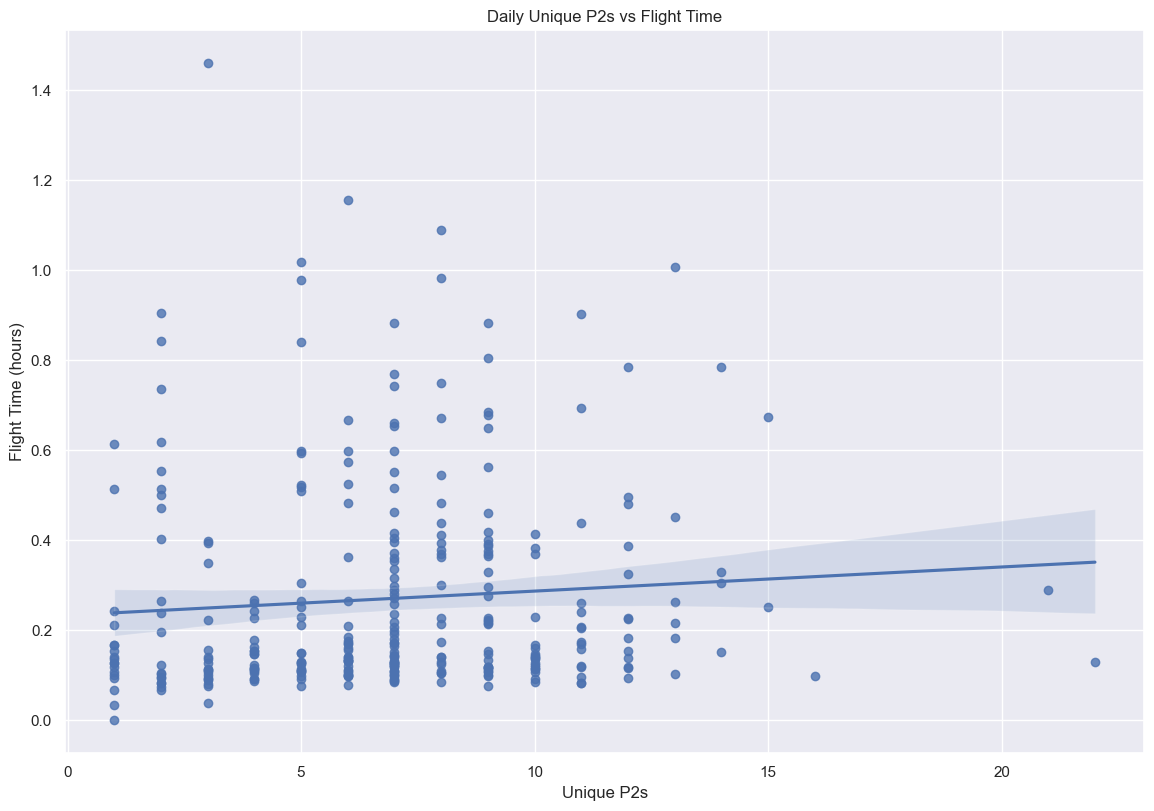

In [24]:
daily_unique_p2_vs_flight_time = day_grouped.aggregate({'FlightTime': 'mean', 'P2': 'nunique'})
# Get rid of open day skewing everything
daily_unique_p2_vs_flight_time = daily_unique_p2_vs_flight_time[daily_unique_p2_vs_flight_time['P2'] < 40]
sns.regplot(x=daily_unique_p2_vs_flight_time['P2'],
                y=daily_unique_p2_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('Unique P2s')
plt.ylabel('Flight Time (hours)')
plt.title('Daily Unique P2s vs Flight Time')
plt.tight_layout()

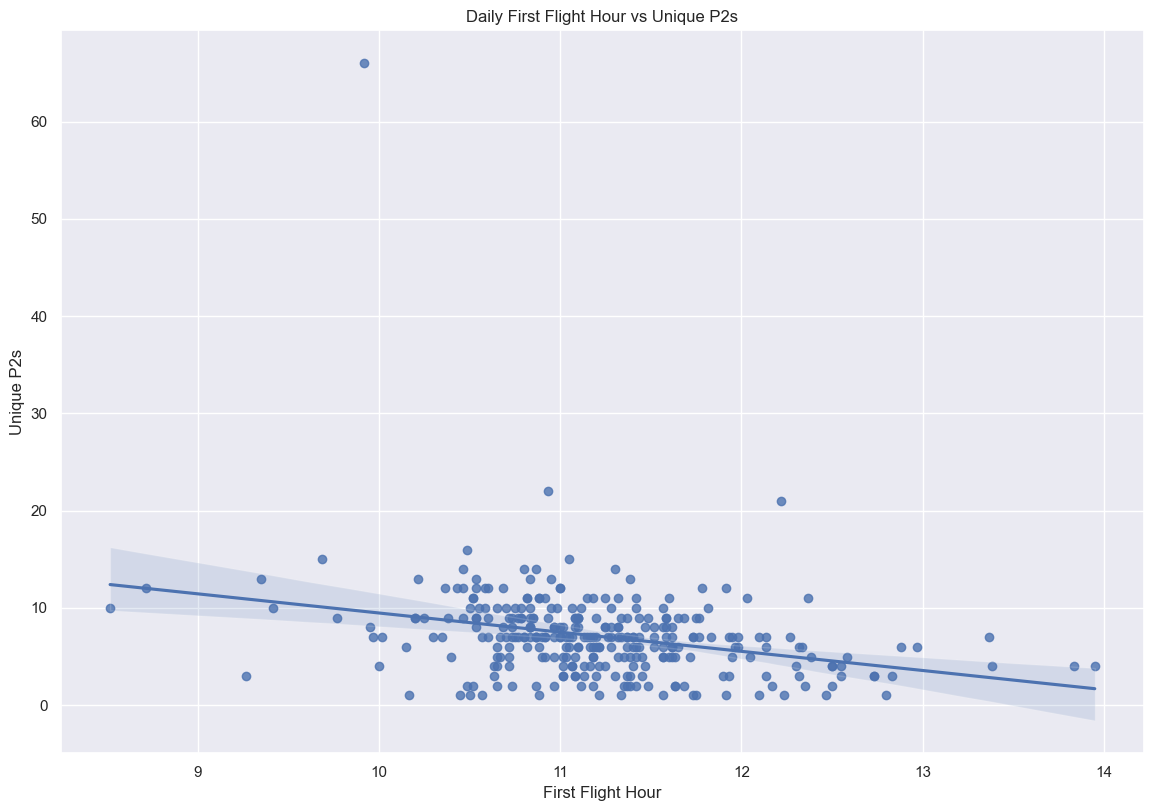

In [25]:
daily_first_flight_hour_vs_unique_p2 = day_grouped.aggregate({'P2': 'nunique', 'TakeoffHour': 'min'})
# Get rid of evening sessions skewing
daily_first_flight_hour_vs_unique_p2 = daily_first_flight_hour_vs_unique_p2[
    daily_first_flight_hour_vs_unique_p2['TakeoffHour'] < 16]
sns.regplot(x=daily_first_flight_hour_vs_unique_p2['TakeoffHour'], y=daily_first_flight_hour_vs_unique_p2['P2'])
plt.xlabel('First Flight Hour')
plt.ylabel('Unique P2s')
plt.title('Daily First Flight Hour vs Unique P2s')
plt.tight_layout()

## Ratio of Solo vs Dual Flying
**Higher P1P2Ratio means more solo flying**

In [26]:
p1_p2_ratio_by_day = day_grouped.aggregate({'P2': 'count', 'TakeoffHour': 'min'}).reset_index()
day_p1_only_flights = flights_df[flights_df['P2'] == ''].groupby('Date').aggregate({'P1': 'count'}).reset_index()
p1_p2_ratio_by_day['Takeoff'] = pd.to_datetime(p1_p2_ratio_by_day['Takeoff'])
p1_p2_ratio_by_day['P1P2Ratio'] = day_p1_only_flights['P1'] / p1_p2_ratio_by_day['P2']

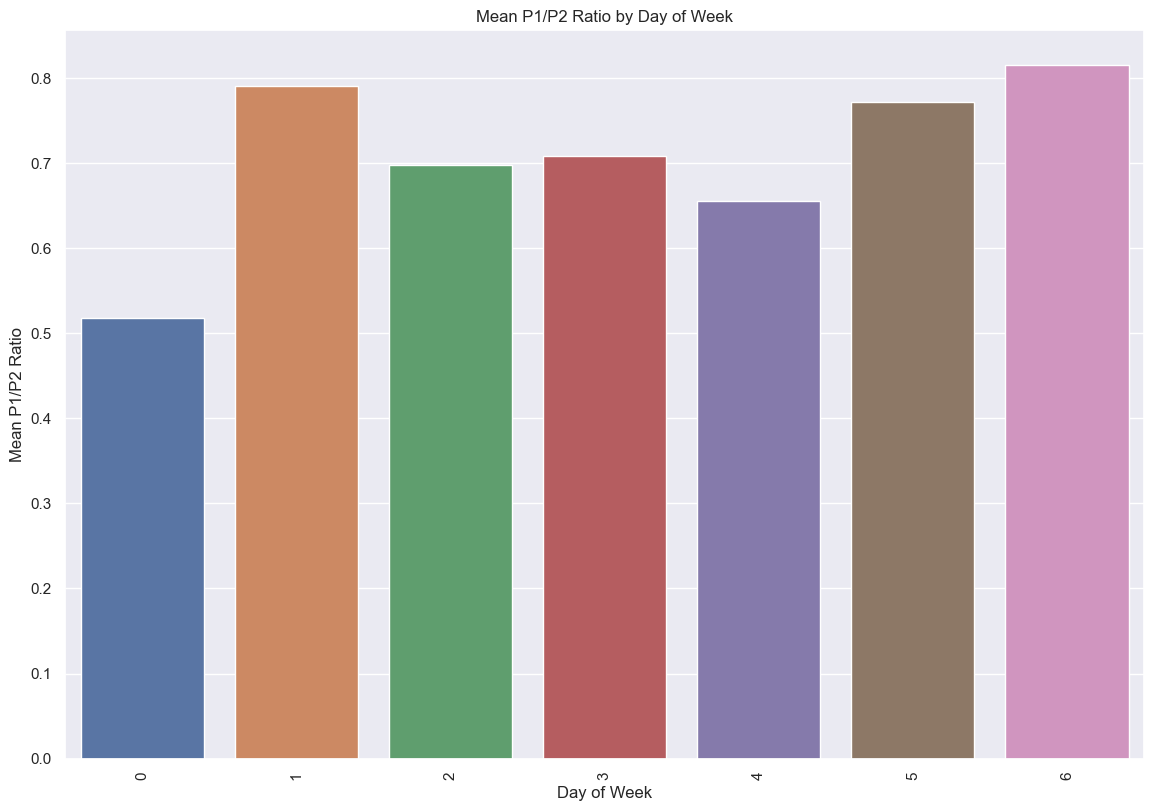

In [27]:
p1_p2_ratio_by_day_of_week = p1_p2_ratio_by_day.groupby(p1_p2_ratio_by_day['Takeoff'].dt.dayofweek).aggregate(
    {'P1P2Ratio': 'mean'})
sns.barplot(x=p1_p2_ratio_by_day_of_week.index, y=p1_p2_ratio_by_day_of_week['P1P2Ratio'])
plt.xticks(rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Mean P1/P2 Ratio')
plt.title('Mean P1/P2 Ratio by Day of Week')
plt.tight_layout()

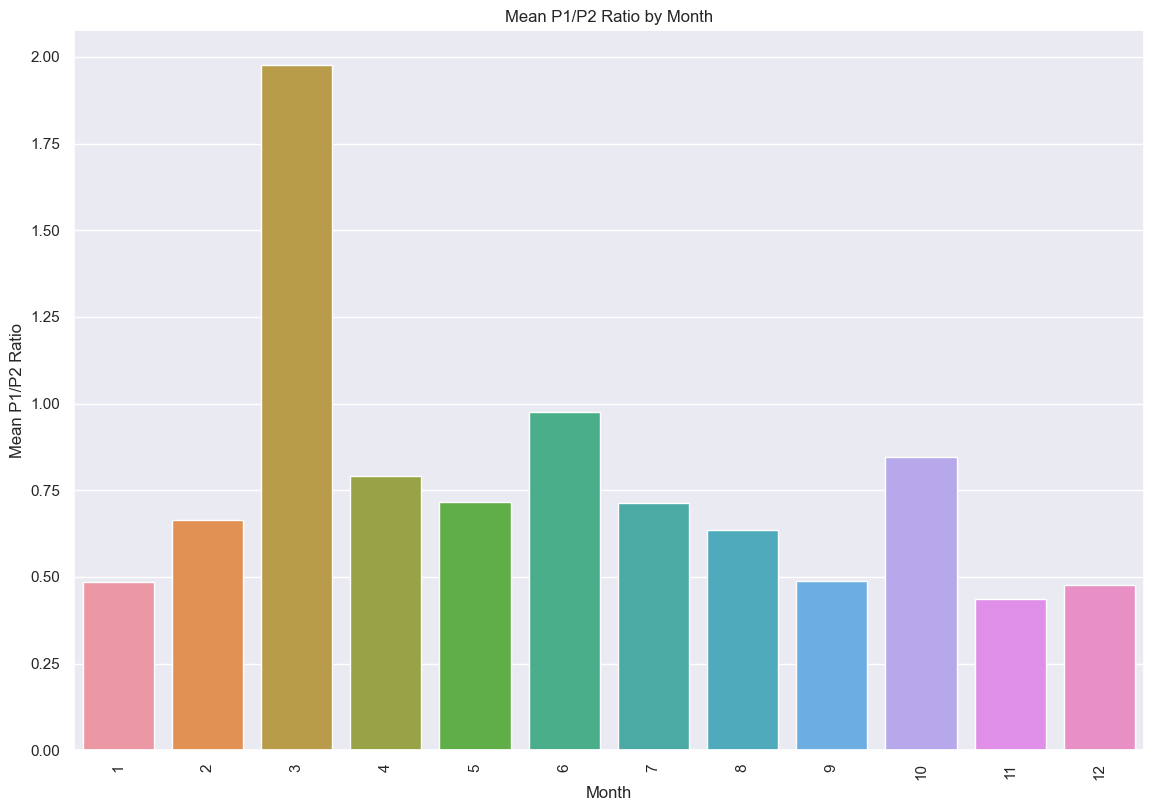

In [28]:
p1_p2_ratio_by_month = p1_p2_ratio_by_day.groupby(p1_p2_ratio_by_day['Takeoff'].dt.month).aggregate(
    {'P1P2Ratio': 'mean'})
sns.barplot(x=p1_p2_ratio_by_month.index, y=p1_p2_ratio_by_month['P1P2Ratio'])
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Mean P1/P2 Ratio')
plt.title('Mean P1/P2 Ratio by Month')
plt.tight_layout()

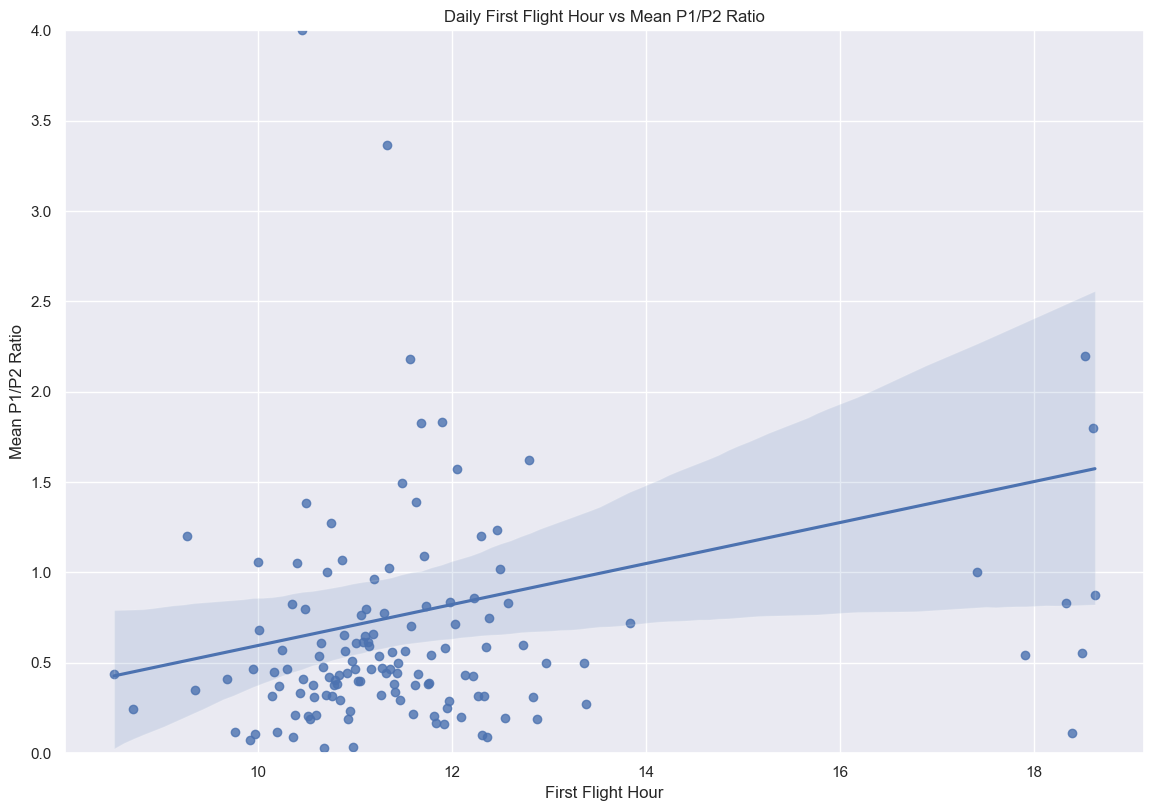

In [29]:
daily_first_flight_hour_vs_p1_p2_ratio = p1_p2_ratio_by_day.groupby(p1_p2_ratio_by_day['TakeoffHour']).aggregate(
    {'P1P2Ratio': 'mean'})
sns.regplot(x=daily_first_flight_hour_vs_p1_p2_ratio.index, y=daily_first_flight_hour_vs_p1_p2_ratio['P1P2Ratio'])
plt.ylim(0, 4)
plt.xlabel('First Flight Hour')
plt.ylabel('Mean P1/P2 Ratio')
plt.title('Daily First Flight Hour vs Mean P1/P2 Ratio')
plt.tight_layout()

# 3. The Weather Comes to Play
Grab some historic weather data and see what happens

In [30]:
import meteostat as ms

In [31]:
SHALBOURNE_LOC = ms.Point(51.343865, -1.542338, 213)

In [32]:
unique_dates = flights_df['Date'].unique()

# Fetch daily data for each date
if os.path.exists('../data/wx_data.json'):
    with open('../data/wx_data.json', 'r') as f:
        daily_data = pd.read_json(f)
else:
    daily_data = pd.concat([ms.Daily(SHALBOURNE_LOC, date, date).fetch() for date in unique_dates],
                           axis=0).reset_index().rename(columns={'index': 'Date'}).replace(np.nan, 0).drop(labels=['tsun'], axis=1)
    with open('../data/wx_data.json', 'w') as f:
        daily_data.to_json(f)


In [33]:
flight_wx_df = flights_df.merge(daily_data, on='Date', how='left')
flight_wx_df.head()

,Date,P1,P2,Glider,Takeoff,FlightTime,Comment,TakeoffMinute,TakeoffHour,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres
0,2019-01-02,Stephen Ottner,Bob Symons,HCF,2019-01-02 11:34:00,0 days 00:05:00,,34,11.566667,2.0,-1.0,4.4,0.0,0.0,25.0,8.9,18.5,1043.8
1,2019-01-02,Bob Boyd,,JPC,2019-01-02 11:38:00,0 days 00:09:00,,38,11.633333,2.0,-1.0,4.4,0.0,0.0,25.0,8.9,18.5,1043.8
2,2019-01-02,Stephen Ottner,Bob Symons,HCF,2019-01-02 11:52:00,0 days 00:02:00,Train launch failure - FOC launch,52,11.866667,2.0,-1.0,4.4,0.0,0.0,25.0,8.9,18.5,1043.8
3,2019-01-02,Colin Baines,Paul Bryant,JPC,2019-01-02 12:07:00,0 days 00:06:00,,7,12.116667,2.0,-1.0,4.4,0.0,0.0,25.0,8.9,18.5,1043.8
4,2019-01-02,Paul Prentice,,DHA,2019-01-02 12:18:00,0 days 00:08:00,,18,12.300000,2.0,-1.0,4.4,0.0,0.0,25.0,8.9,18.5,1043.8


In [34]:
day_wx_grouped = flight_wx_df.groupby('Date')

## Wind Direction

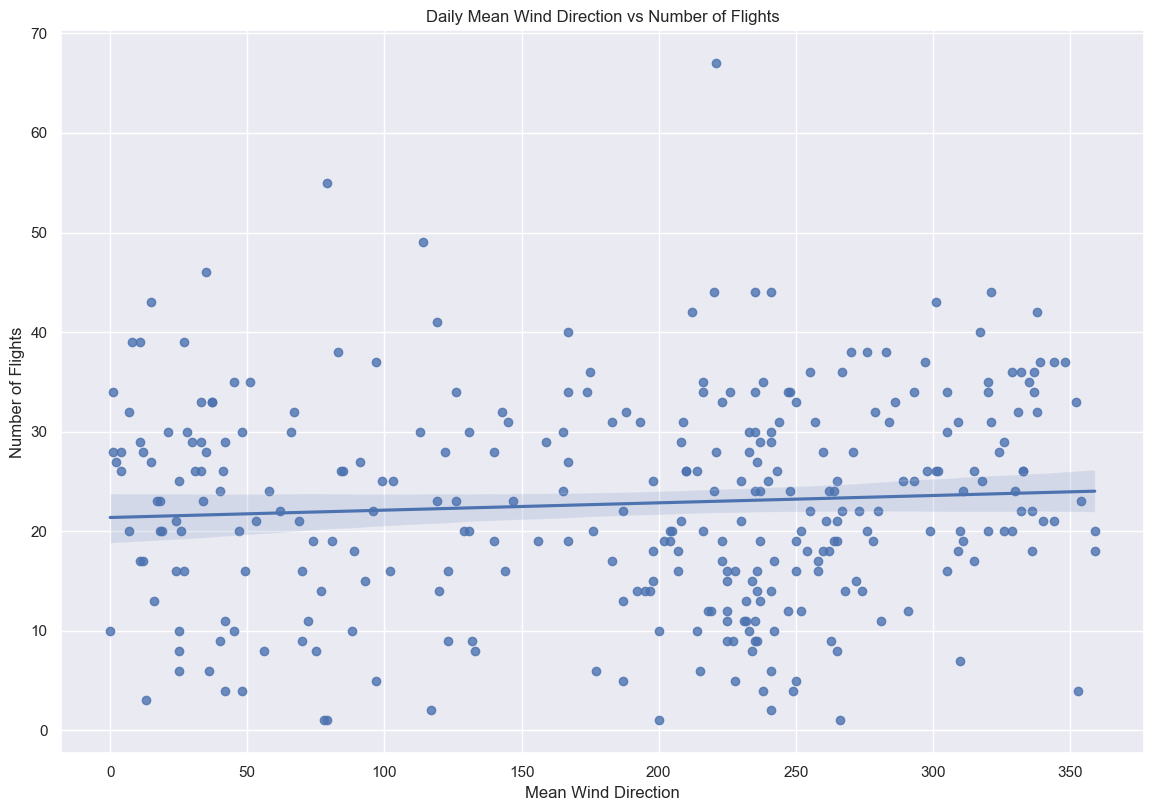

In [35]:
daily_wdir_vs_takeoff_count = day_wx_grouped.aggregate({'wdir': 'mean', 'Takeoff': 'count'})
sns.regplot(x=daily_wdir_vs_takeoff_count['wdir'], y=daily_wdir_vs_takeoff_count['Takeoff'])
plt.xlabel('Mean Wind Direction')
plt.ylabel('Number of Flights')
plt.title('Daily Mean Wind Direction vs Number of Flights')
plt.tight_layout()

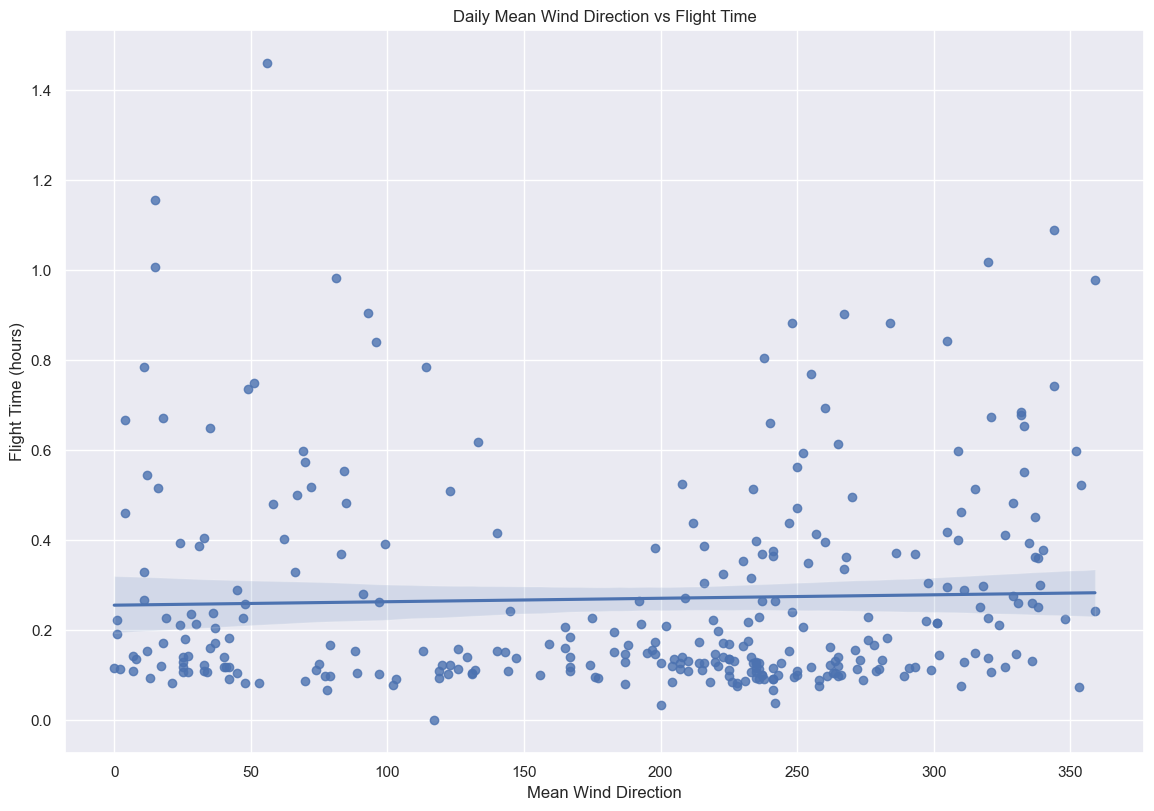

In [36]:
daily_wdir_vs_flight_time = day_wx_grouped.aggregate({'wdir': 'mean', 'FlightTime': 'mean'})
sns.regplot(x=daily_wdir_vs_flight_time['wdir'], y=daily_wdir_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('Mean Wind Direction')
plt.ylabel('Flight Time (hours)')
plt.title('Daily Mean Wind Direction vs Flight Time')
plt.tight_layout()

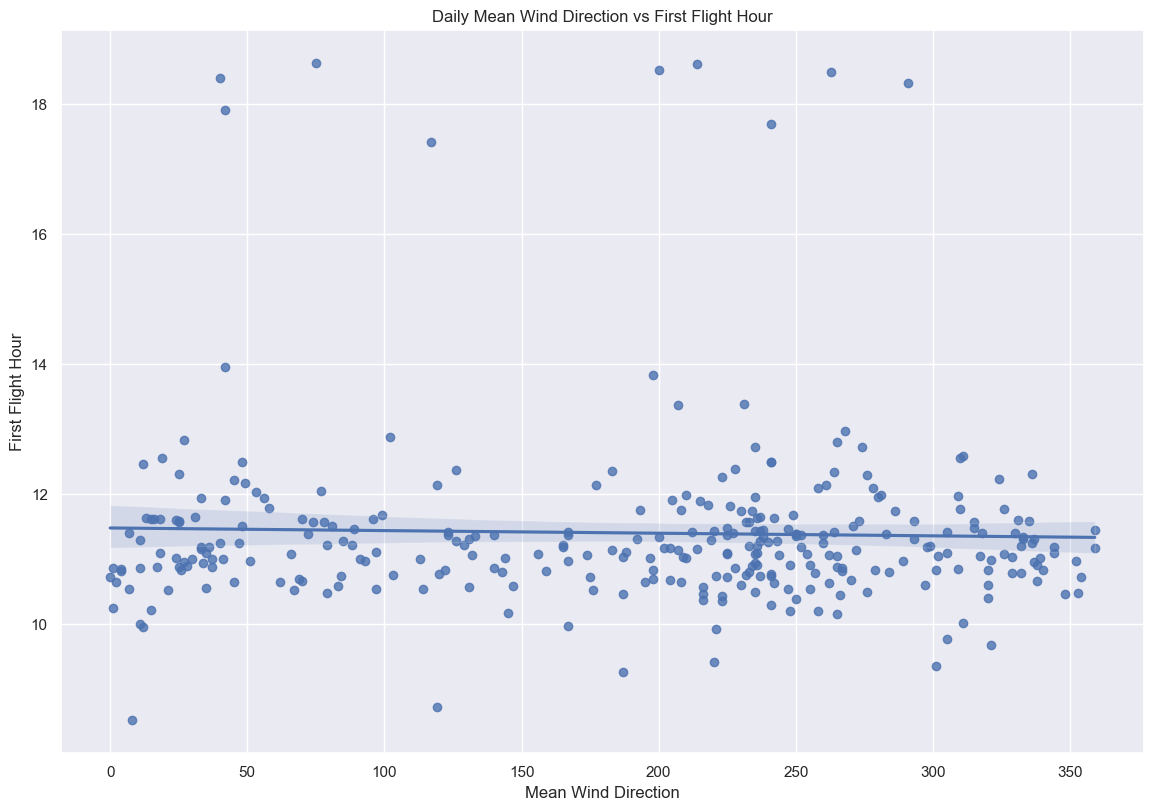

In [37]:
daily_wdir_vs_first_flight_hour = day_wx_grouped.aggregate({'wdir': 'mean', 'TakeoffHour': 'min'})
sns.regplot(x=daily_wdir_vs_first_flight_hour['wdir'], y=daily_wdir_vs_first_flight_hour['TakeoffHour'])
plt.xlabel('Mean Wind Direction')
plt.ylabel('First Flight Hour')
plt.title('Daily Mean Wind Direction vs First Flight Hour')
plt.tight_layout()

## Wind Speed

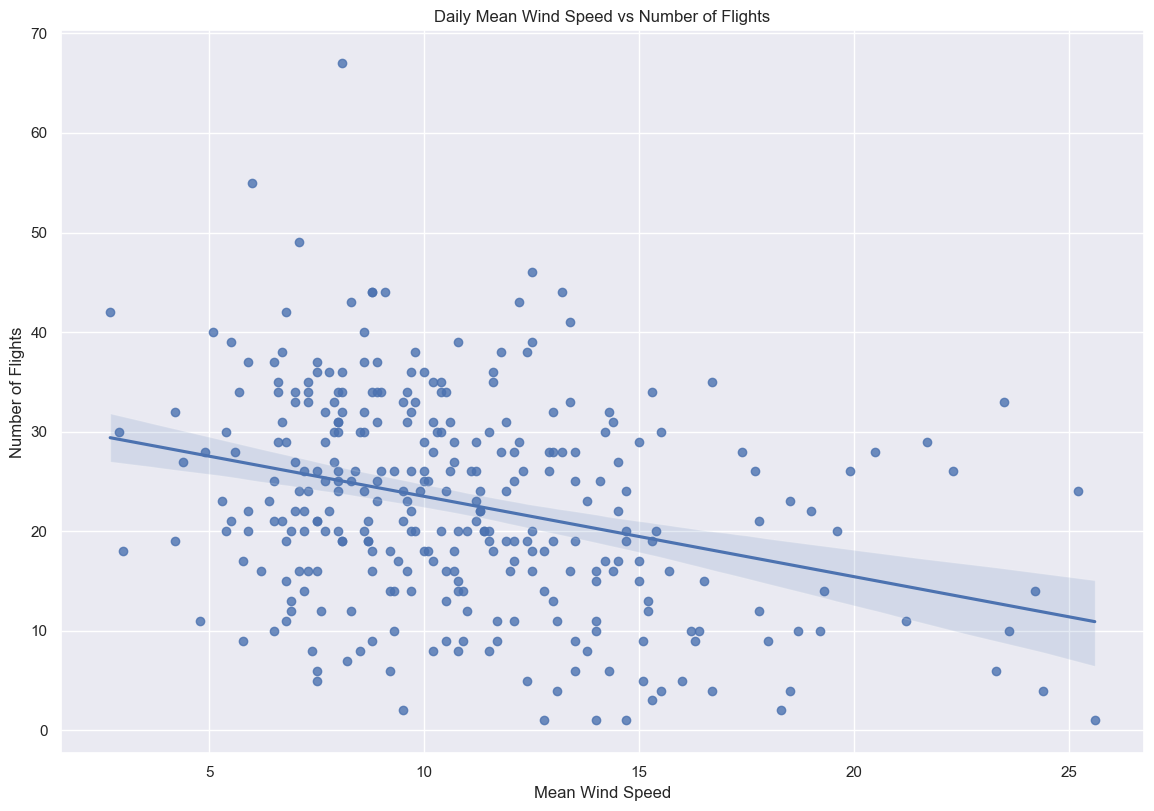

In [38]:
daily_wspd_vs_takeoff_count = day_wx_grouped.aggregate({'wspd': 'mean', 'Takeoff': 'count'})
sns.regplot(x=daily_wspd_vs_takeoff_count['wspd'], y=daily_wspd_vs_takeoff_count['Takeoff'])
plt.xlabel('Mean Wind Speed')
plt.ylabel('Number of Flights')
plt.title('Daily Mean Wind Speed vs Number of Flights')
plt.tight_layout()

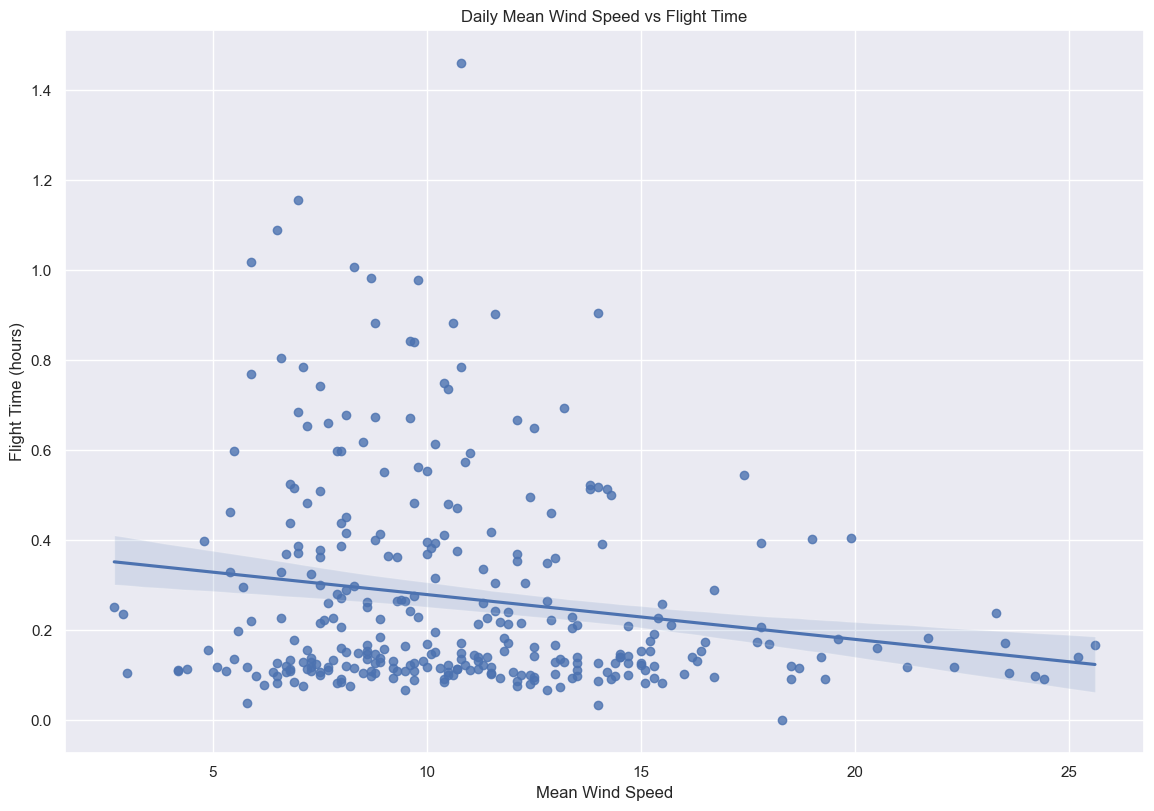

In [39]:
daily_wspd_vs_flight_time = day_wx_grouped.aggregate({'wspd': 'mean', 'FlightTime': 'mean'})
sns.regplot(x=daily_wspd_vs_flight_time['wspd'], y=daily_wspd_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('Mean Wind Speed')
plt.ylabel('Flight Time (hours)')
plt.title('Daily Mean Wind Speed vs Flight Time')
plt.tight_layout()

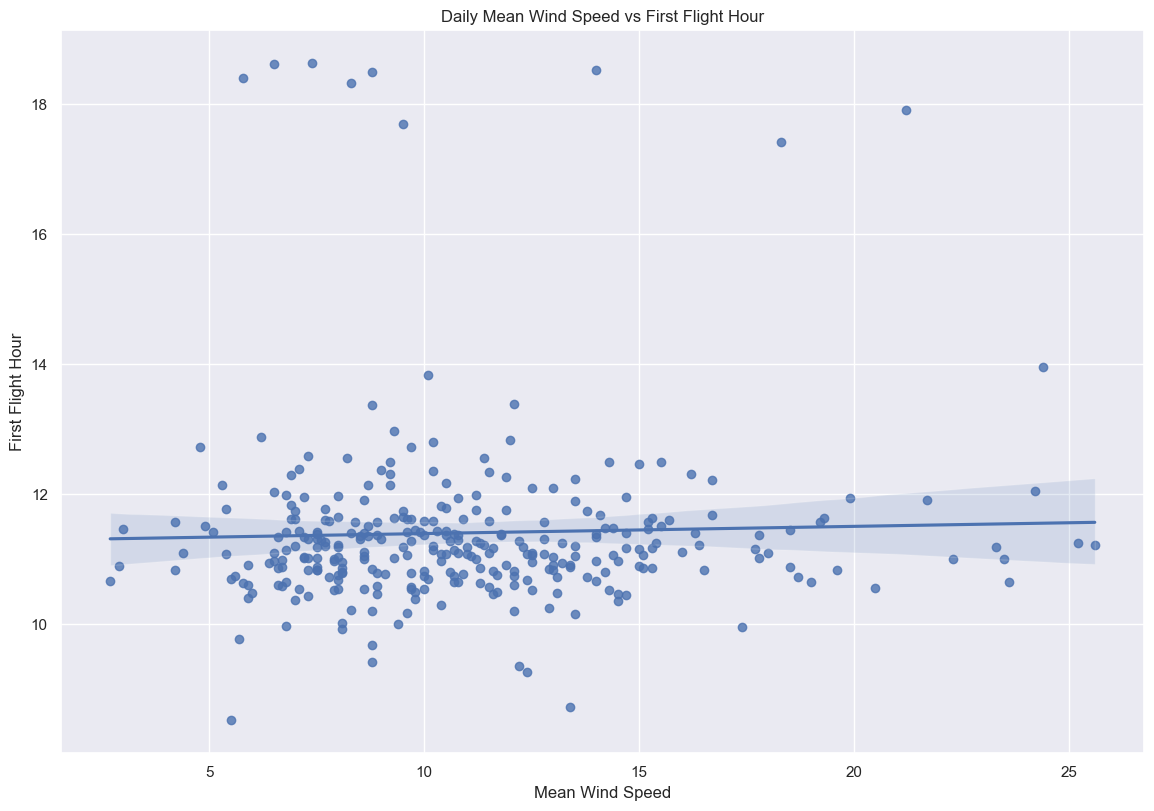

In [40]:
daily_wspd_vs_first_flight_hour = day_wx_grouped.aggregate({'wspd': 'mean', 'TakeoffHour': 'min'})
sns.regplot(x=daily_wspd_vs_first_flight_hour['wspd'], y=daily_wspd_vs_first_flight_hour['TakeoffHour'])
plt.xlabel('Mean Wind Speed')
plt.ylabel('First Flight Hour')
plt.title('Daily Mean Wind Speed vs First Flight Hour')
plt.tight_layout()

## Temperature

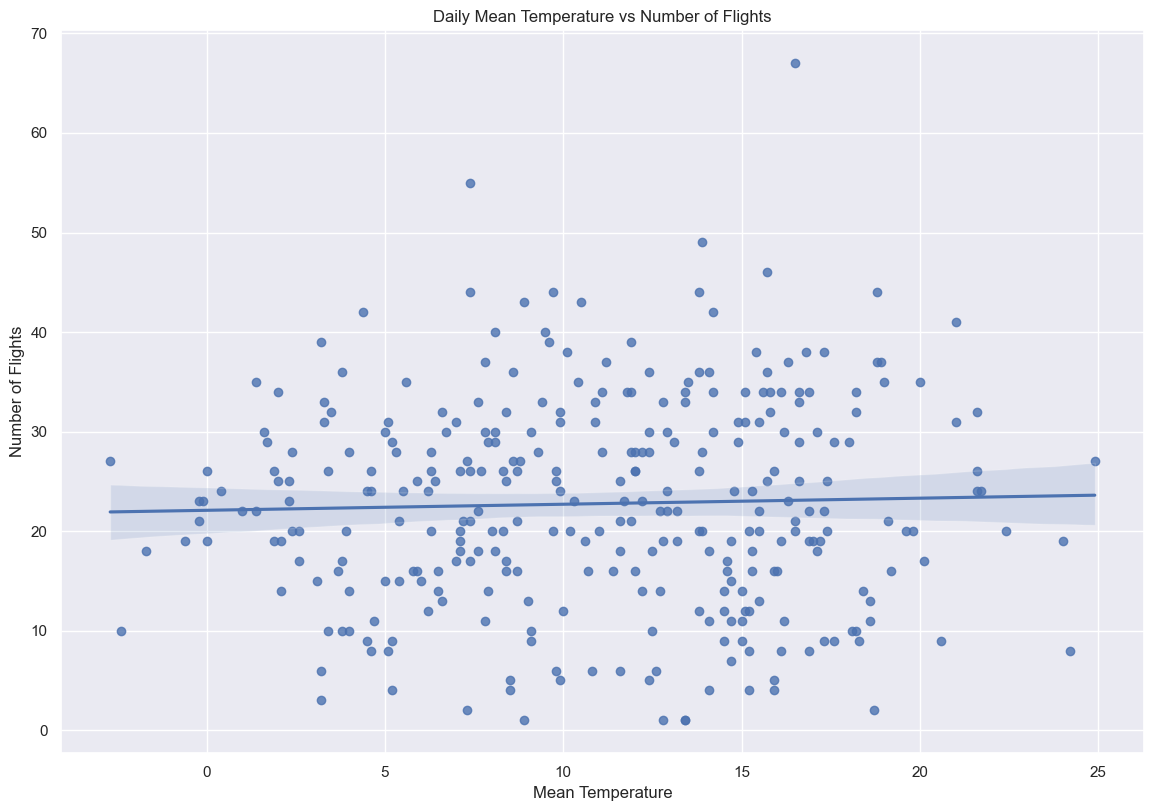

In [41]:
daily_temp_vs_takeoff_count = day_wx_grouped.aggregate({'tavg': 'mean', 'Takeoff': 'count'})
sns.regplot(x=daily_temp_vs_takeoff_count['tavg'], y=daily_temp_vs_takeoff_count['Takeoff'])
plt.xlabel('Mean Temperature')
plt.ylabel('Number of Flights')
plt.title('Daily Mean Temperature vs Number of Flights')
plt.tight_layout()

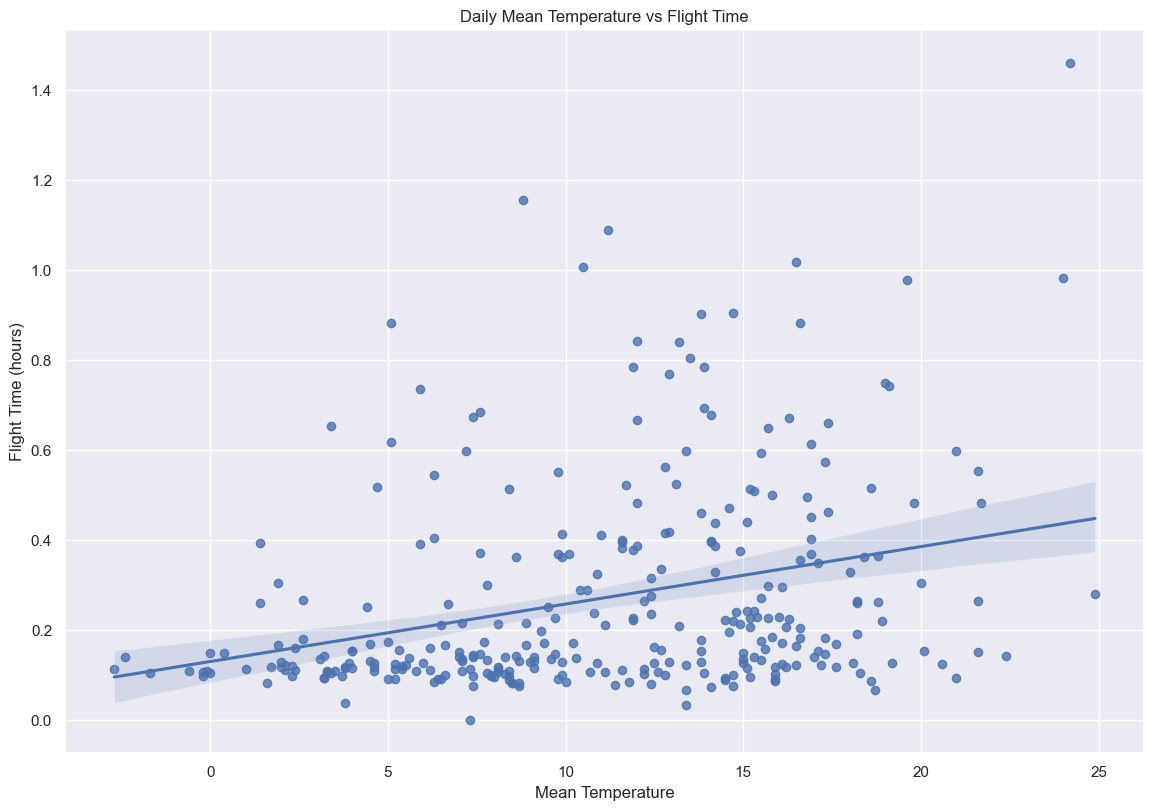

In [42]:
daily_temp_vs_flight_time = day_wx_grouped.aggregate({'tavg': 'mean', 'FlightTime': 'mean'})
sns.regplot(x=daily_temp_vs_flight_time['tavg'], y=daily_temp_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('Mean Temperature')
plt.ylabel('Flight Time (hours)')
plt.title('Daily Mean Temperature vs Flight Time')
plt.tight_layout()

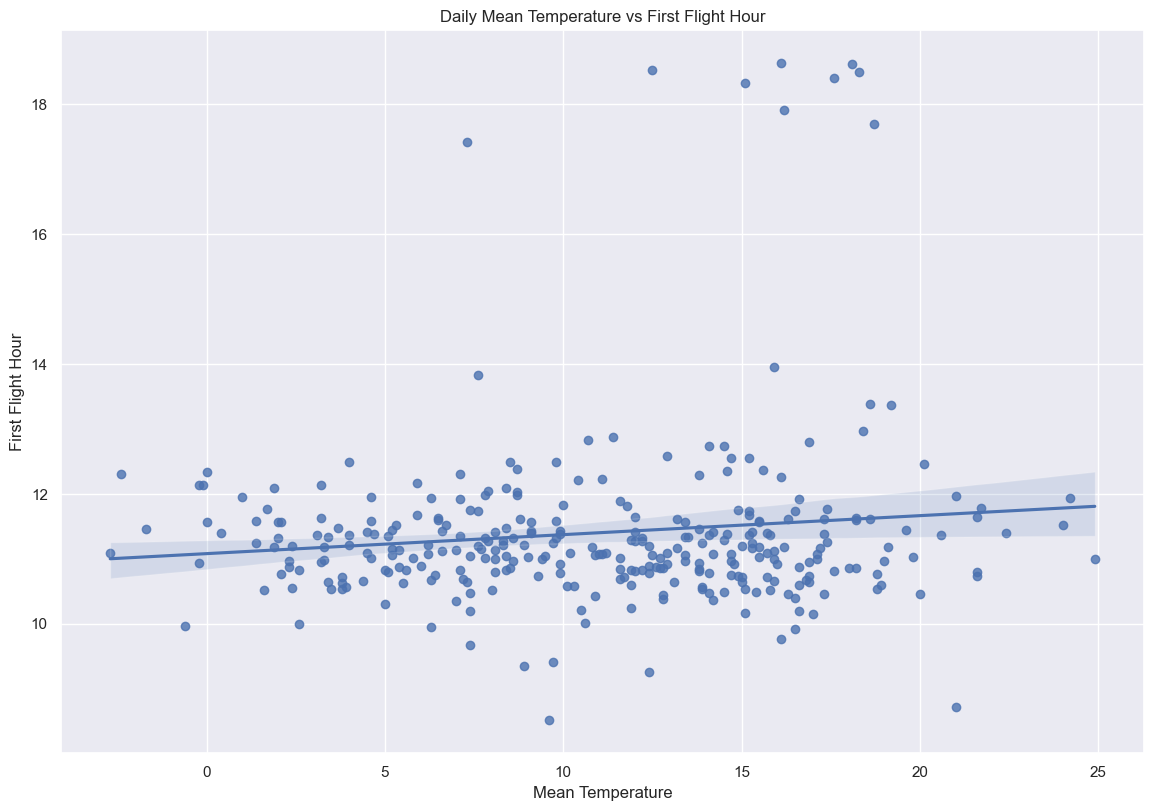

In [43]:
daily_temp_vs_first_flight_hour = day_wx_grouped.aggregate({'tavg': 'mean', 'TakeoffHour': 'min'})
sns.regplot(x=daily_temp_vs_first_flight_hour['tavg'], y=daily_temp_vs_first_flight_hour['TakeoffHour'])
plt.xlabel('Mean Temperature')
plt.ylabel('First Flight Hour')
plt.title('Daily Mean Temperature vs First Flight Hour')
plt.tight_layout()

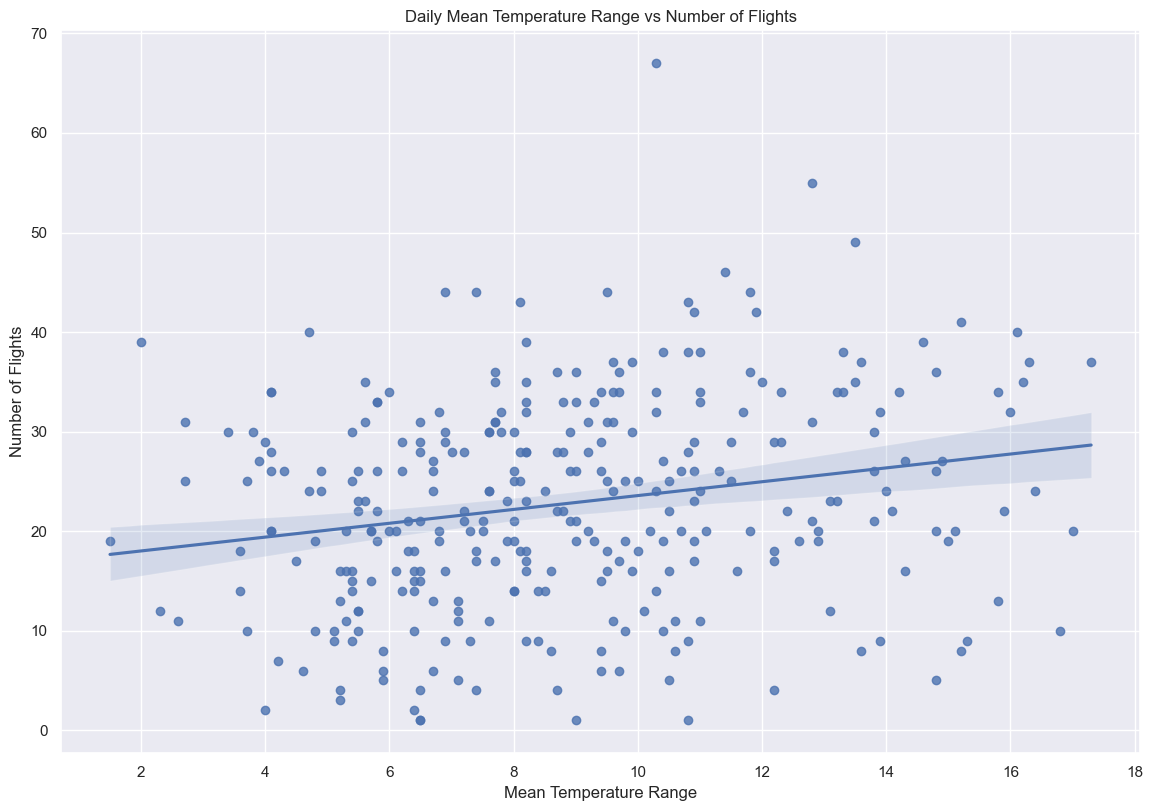

In [44]:
daily_temp_range_vs_takeoff_count = day_wx_grouped.aggregate({'tmin': 'mean', 'tmax': 'mean', 'Takeoff': 'count'})
sns.regplot(x=daily_temp_range_vs_takeoff_count['tmax'] - daily_temp_range_vs_takeoff_count['tmin'],
                y=daily_temp_range_vs_takeoff_count['Takeoff'])
plt.xlabel('Mean Temperature Range')
plt.ylabel('Number of Flights')
plt.title('Daily Mean Temperature Range vs Number of Flights')
plt.tight_layout()

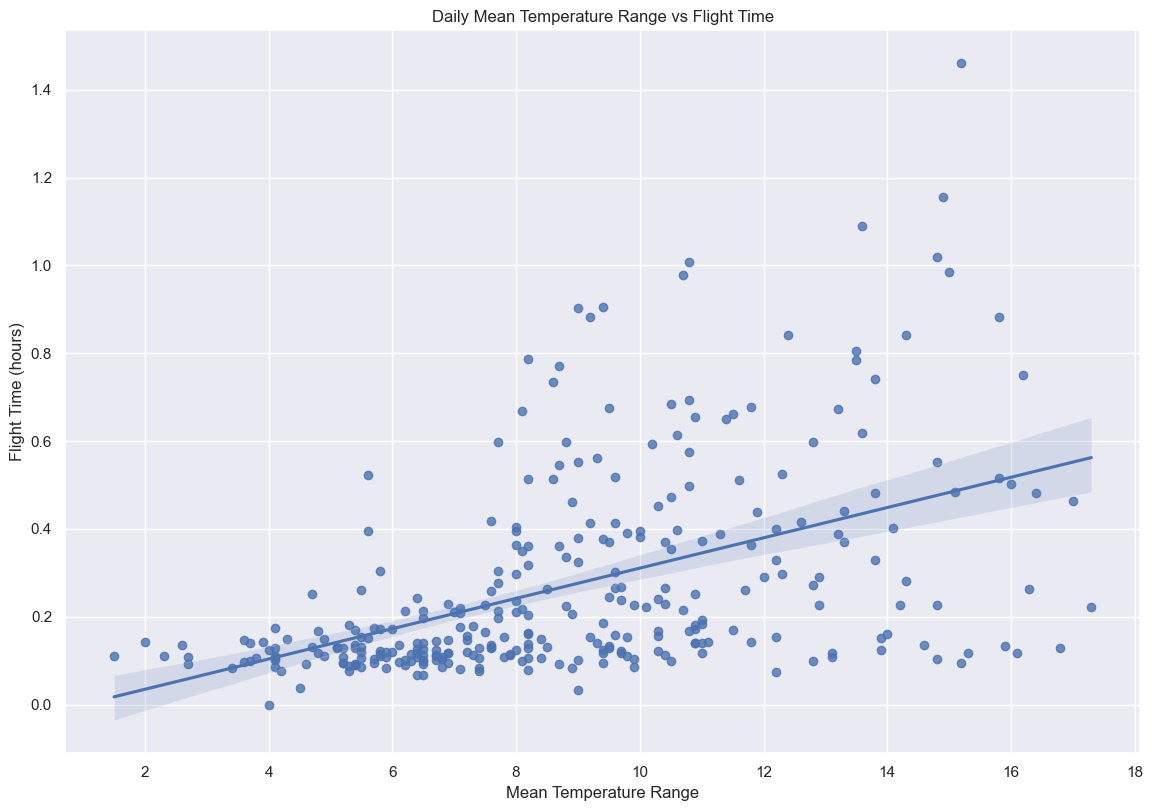

In [45]:
daily_temp_range_vs_flight_time = day_wx_grouped.aggregate({'tmin': 'mean', 'tmax': 'mean', 'FlightTime': 'mean'})
sns.regplot(x=daily_temp_range_vs_flight_time['tmax'] - daily_temp_range_vs_flight_time['tmin'],
                y=daily_temp_range_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('Mean Temperature Range')
plt.ylabel('Flight Time (hours)')
plt.title('Daily Mean Temperature Range vs Flight Time')
plt.tight_layout()

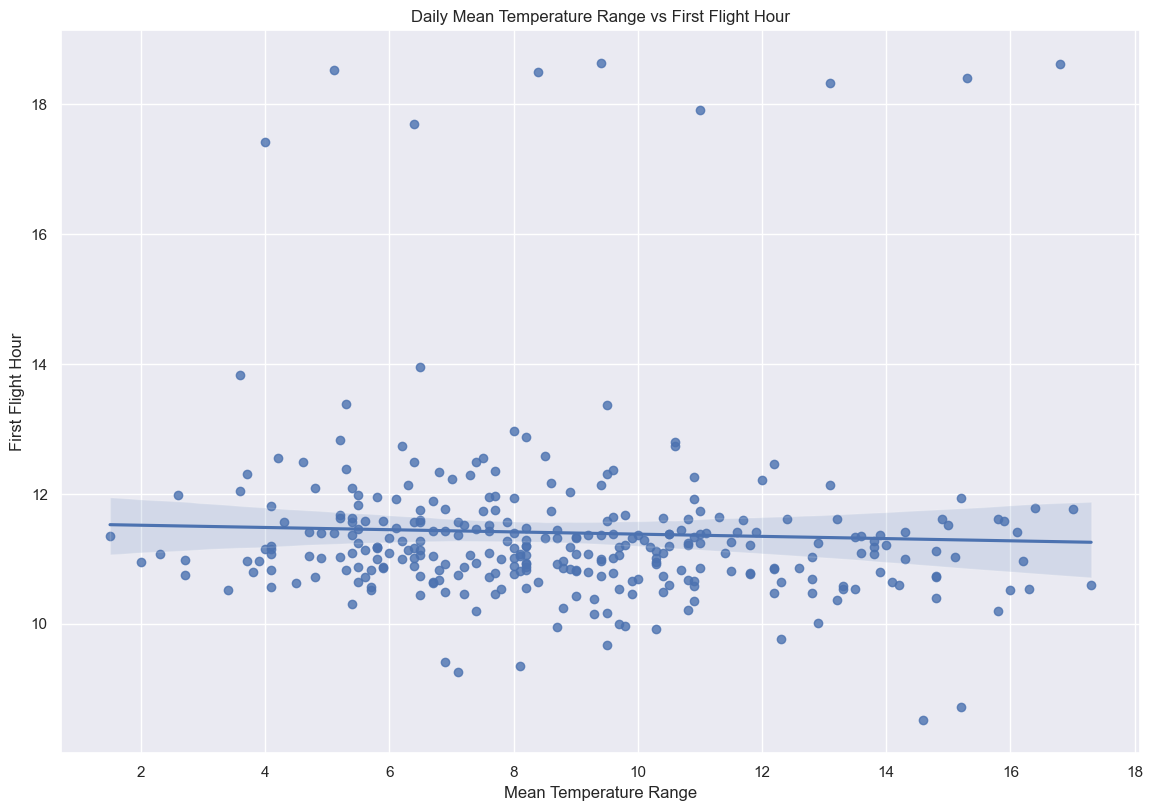

In [46]:
daily_temp_range_vs_first_flight_hour = day_wx_grouped.aggregate({'tmin': 'mean', 'tmax': 'mean', 'TakeoffHour': 'min'})
# sns.regplot(x=daily_temp_range_vs_first_flight_hour['tmax'] - daily_temp_range_vs_first_flight_hour['tmin'],
#                 y=daily_temp_range_vs_first_flight_hour['TakeoffHour'])
sns.regplot(x=daily_temp_range_vs_first_flight_hour['tmax'] - daily_temp_range_vs_first_flight_hour['tmin'],
            y=daily_temp_range_vs_first_flight_hour['TakeoffHour'])
plt.xlabel('Mean Temperature Range')
plt.ylabel('First Flight Hour')
plt.title('Daily Mean Temperature Range vs First Flight Hour')
plt.tight_layout()

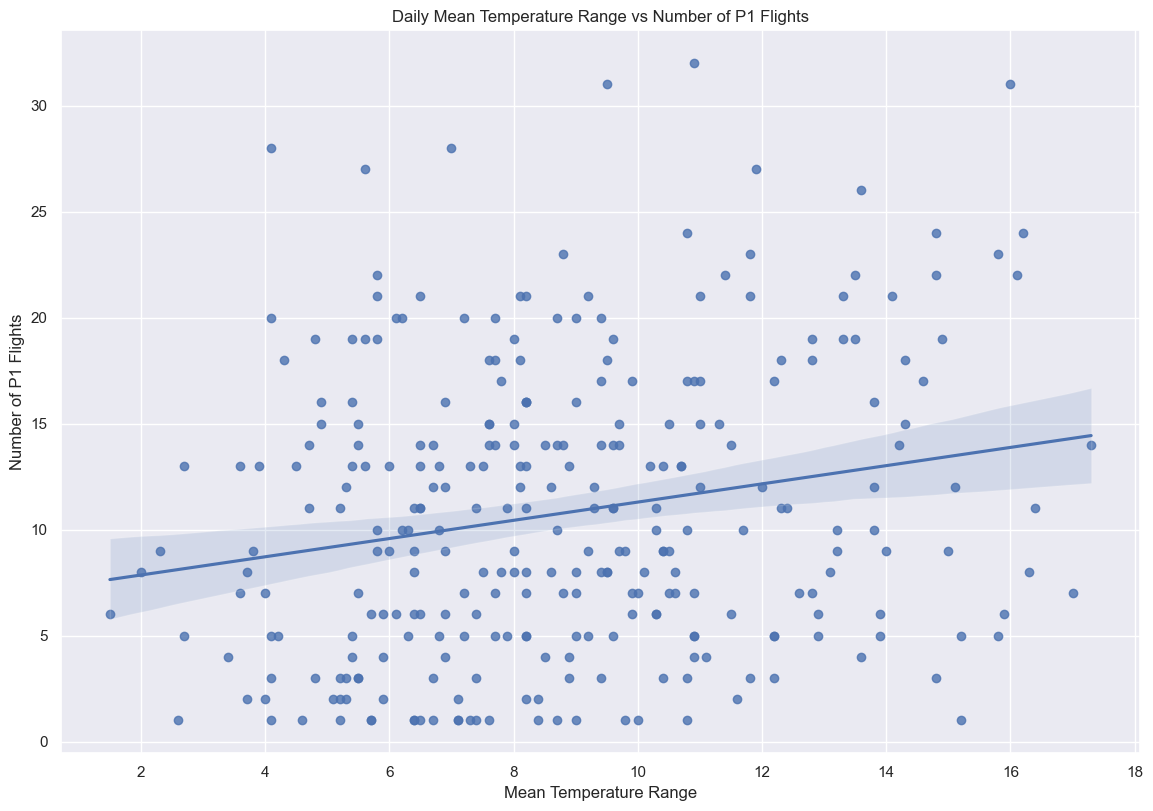

In [47]:
day_p1_only_flights_wx = flight_wx_df[flight_wx_df['P2'] == ''].groupby('Date').aggregate({'P1': 'count', 'FlightTime': 'mean'}).reset_index().merge(daily_data, on='Date', how='left')
day_p1_only_flights_wx['FlightTime'] = pd.to_timedelta(day_p1_only_flights_wx['FlightTime'])

daily_temp_range_vs_p1_flight_time = day_p1_only_flights_wx.groupby(['tmin', 'tmax']).aggregate({'P1': 'sum', 'FlightTime': 'mean'}).reset_index()
daily_temp_range_vs_p1_flight_time['FlightTime'] = daily_temp_range_vs_p1_flight_time['FlightTime'].dt.total_seconds() / 3600
daily_temp_range_vs_p1_flight_time['t_range'] = daily_temp_range_vs_p1_flight_time['tmax'] - daily_temp_range_vs_p1_flight_time['tmin']
sns.regplot(x=daily_temp_range_vs_p1_flight_time['t_range'], y=daily_temp_range_vs_p1_flight_time['P1'])
plt.xlabel('Mean Temperature Range')
plt.ylabel('Number of P1 Flights')
plt.title('Daily Mean Temperature Range vs Number of P1 Flights')
plt.tight_layout()

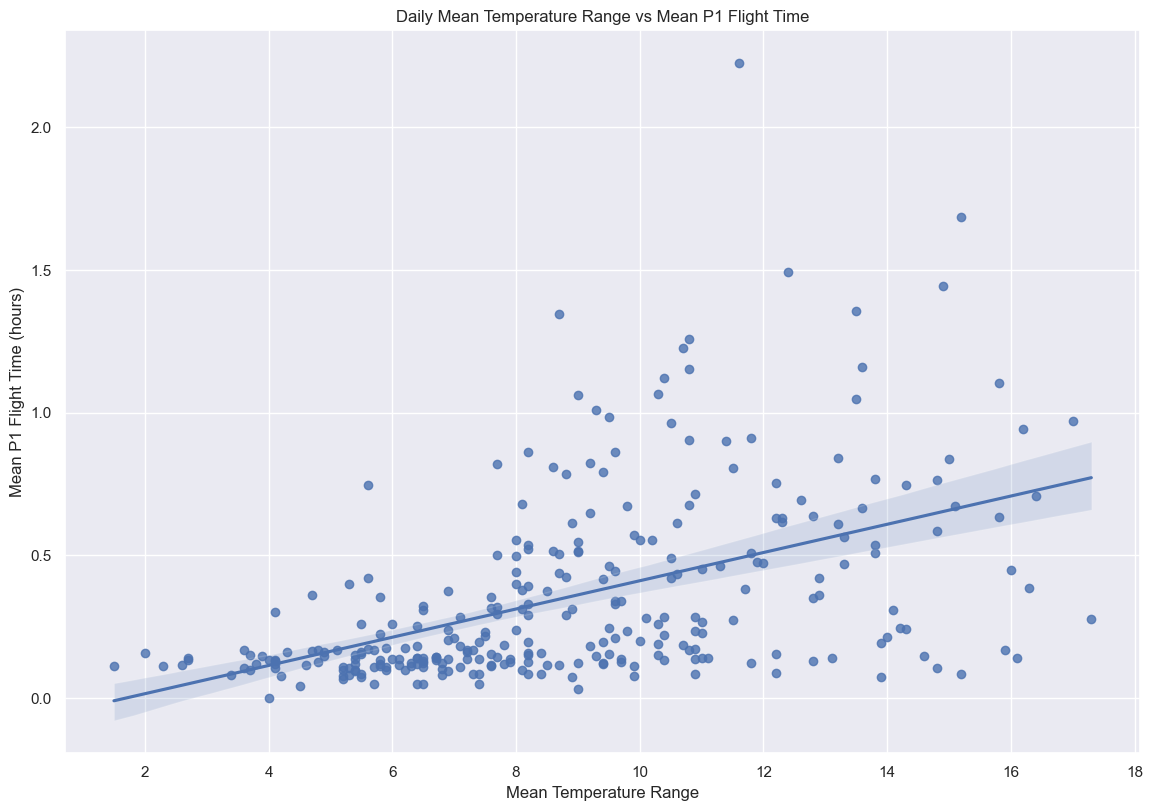

In [48]:
sns.regplot(x=daily_temp_range_vs_p1_flight_time['t_range'], y=daily_temp_range_vs_p1_flight_time['FlightTime'])
plt.xlabel('Mean Temperature Range')
plt.ylabel('Mean P1 Flight Time (hours)')
plt.title('Daily Mean Temperature Range vs Mean P1 Flight Time')
plt.tight_layout()

## Pressure

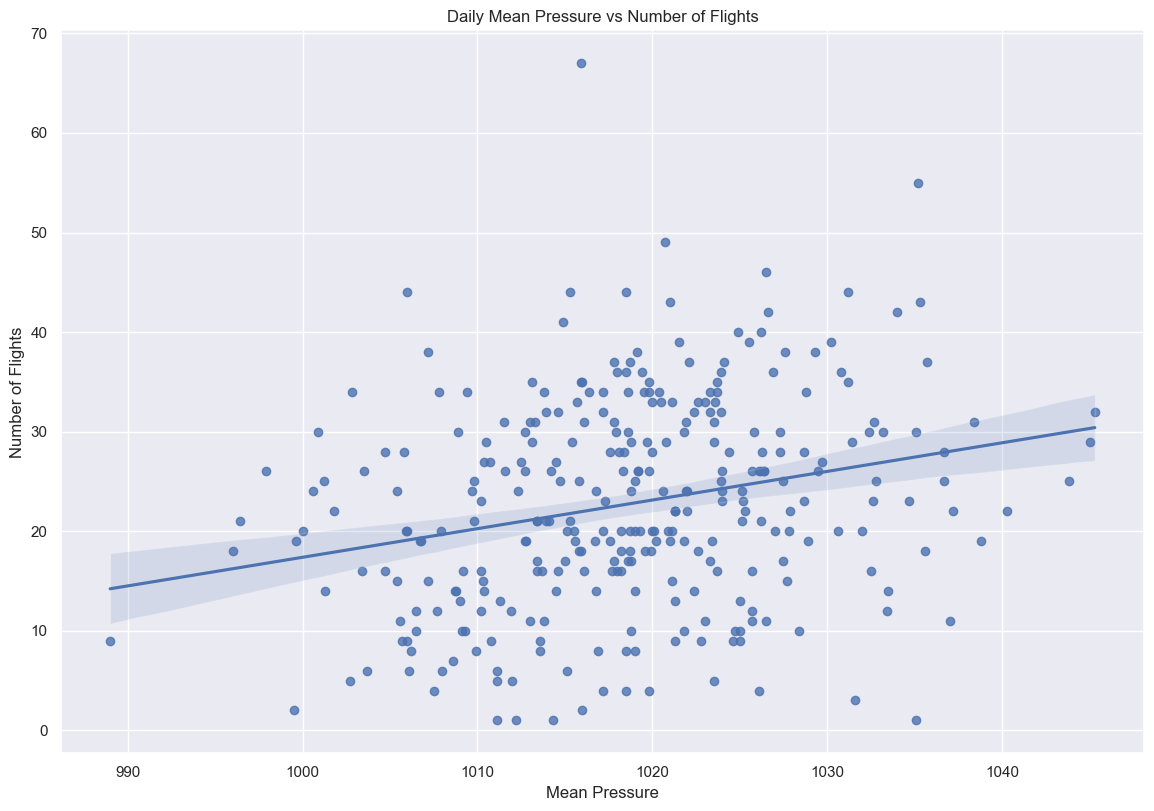

In [49]:
daily_pressure_vs_takeoff_count = day_wx_grouped.aggregate({'pres': 'mean', 'Takeoff': 'count'})
sns.regplot(x=daily_pressure_vs_takeoff_count['pres'], y=daily_pressure_vs_takeoff_count['Takeoff'])
plt.xlabel('Mean Pressure')
plt.ylabel('Number of Flights')
plt.title('Daily Mean Pressure vs Number of Flights')
plt.tight_layout()

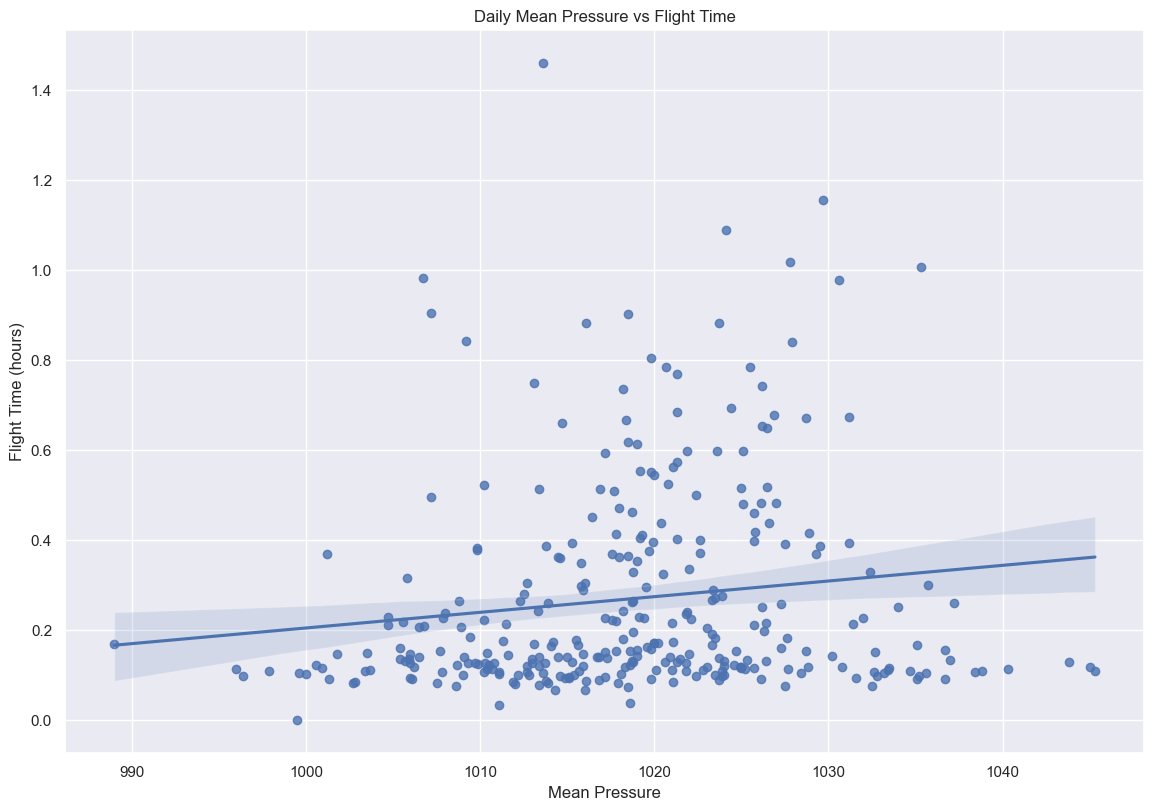

In [50]:
daily_pressure_vs_flight_time = day_wx_grouped.aggregate({'pres': 'mean', 'FlightTime': 'mean'})
sns.regplot(x=daily_pressure_vs_flight_time['pres'], y=daily_pressure_vs_flight_time['FlightTime'].dt.total_seconds() / 3600)
plt.xlabel('Mean Pressure')
plt.ylabel('Flight Time (hours)')
plt.title('Daily Mean Pressure vs Flight Time')
plt.tight_layout()

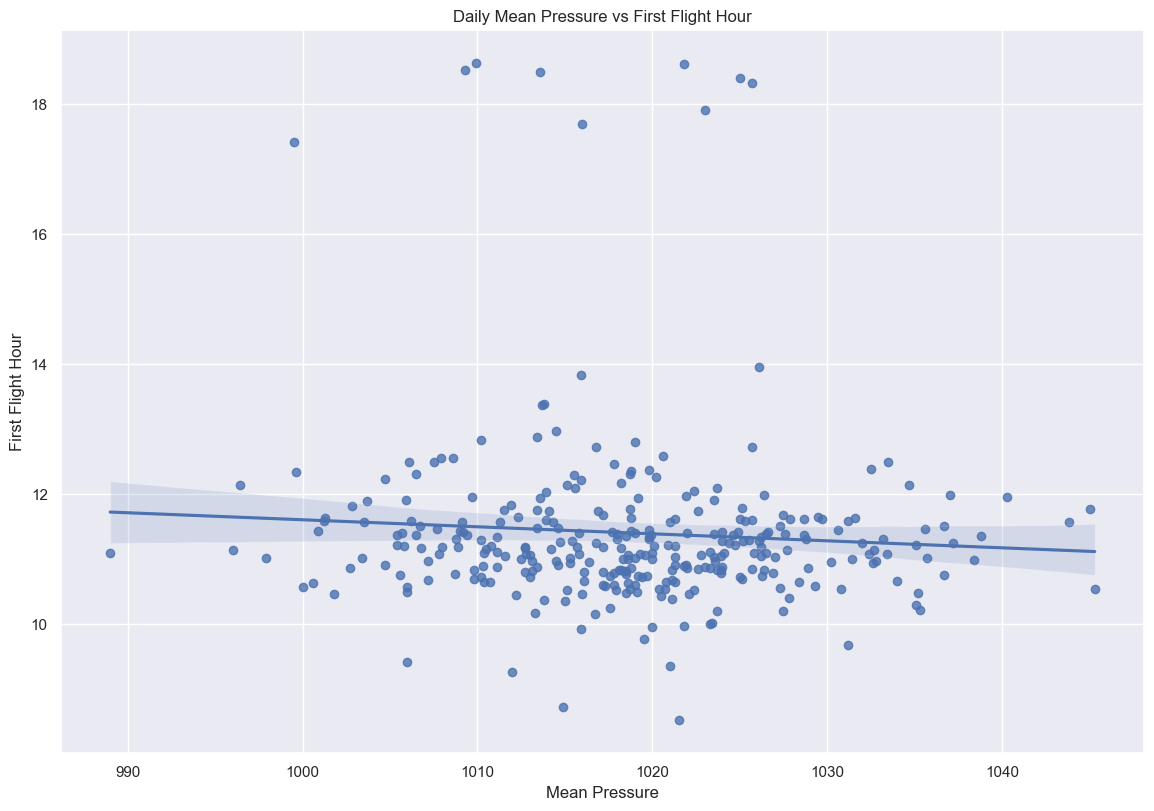

In [51]:
daily_pressure_vs_first_flight_hour = day_wx_grouped.aggregate({'pres': 'mean', 'TakeoffHour': 'min'})
sns.regplot(x=daily_pressure_vs_first_flight_hour['pres'], y=daily_pressure_vs_first_flight_hour['TakeoffHour'])
plt.xlabel('Mean Pressure')
plt.ylabel('First Flight Hour')
plt.title('Daily Mean Pressure vs First Flight Hour')
plt.tight_layout()